In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')
import string

!pip install gensim
import gensim
from gensim import corpora, models

from collections import Counter
import gensim,logging, warnings
warnings.filterwarnings("ignore")
!pip install pyLDAvis
from pyLDAvis import gensim
from gensim.models import ldamodel
import pyLDAvis
import pyLDAvis.sklearn
from pyLDAvis import sklearn as sklearn_lda


In [ ]:
!wget https://raw.githubusercontent.com/JSC370/jsc370.github.io/master/enron_top_exe_mails.csv

In [ ]:
enron = pd.read_csv("enron_top_exe_mails.csv")
df = pd.DataFrame(enron)

In [ ]:
df = df.drop("Unnamed: 0", axis=1)

In [ ]:
# text preprocessing 

df["text"] = df['text'].apply(lambda x: x.strip('[]')) 
df["text"] = df['text'].apply(lambda x: x.strip("'',"))
df["text"] = df['text'].apply(lambda x: x.strip(", '',"))




# remove "From" from sender mail ids
def remove_from(text): 
    mail = re.sub(r'From:', '', text)
    return mail

# remove "To" from recipient mail ids
def remove_to(text): 
    mail = re.sub(r'To:', '', text)
    return mail

#remove unnecessary line breakers 
def remove_obj(text): 
    mail = re.sub('\'', '', text)
    return mail

#defin a function to remove punctuation from text
def remove_punct(text):
    punct = "".join([i for i in text if i not in string.punctuation])
    return punct

# remove numbers from mail body 
def remove_numbers(text): 
    mail = re.sub(r"\d+", "", text)
    return mail



# applying all defined functions 
df['senders'] = df['senders'].apply(lambda x : remove_from(x))

df['recipients'] = df['recipients'].apply(lambda x : remove_to(x))

df['text'] = df['text'].apply(lambda x : remove_obj(x))

df['text'] = df['text'].apply(lambda x : remove_punct(x)) 

df['text'] = df['text'].apply(lambda x : remove_numbers(x))


# **Natural Language Processing**

**Haiyue Yang, Yun Shen, Xin Peng**

Enron was an American energy company and was one of the largest electricity and natural gas companies in the world. However, at the end of 2001, its financial condition was revealed to be an accounting fraud. The Federal Energy Regulatory Commission (FERC) has generated many Enron emails during the investigation. 

We are using 1980 Enron emails of Enron's top executives to provide an overview of Enron Scandal and recommendations for who to investigate at what times on what general topics by using Natural Language Processing.

And we have explored the data, brainstormed what factors could help improve the investigation recommendation, proposed several models, and implemented the variants below.

# Add-on Value of the Data

* Find evidence of fraud.
* Extract frequent keywords to determine what are the important topics in these emails.
* Cover frequently asked questions in training
Detect people who make fraud and block them to ensure safety in working environment.
* Analyze employees' social networks to see which group of people work closely.
* Filter out junk emails.


# Key Metrics to Measure Success

* Accuracy of correctly detecting fraud
* Less pecuniary loss due to fraud
* Quicker response to fraud which benefits internal management of the company
* For the topic model, we want to see if the actual emails match the results. (i.e. When the topic model suggests the topic of the email, we want to see if it correcly categorize the topic.)


# Data Exploration

## Problem with the data

First, we have discovered some problems with the data. One is that some dates are not correctly recorded. The other one is that there are many duplicate emails in the dataset.

In [ ]:
df.sort_values(by=['date']).head(10)

,file,message,text,date,senders,recipients,subject
184,kean-s/all_documents/121.,Message-ID: <7230661.1075846142733.JavaMail.ev...,Xbcc XFolder StevenKeanDecNotes FoldersAll do...,1979-12-31 16:00:00-08:00,steven.kean@enron.com,kenneth.lay@enron.com,Further information regarding Gov Thompson
290,kean-s/discussion_threads/120.,Message-ID: <2828867.1075848072222.JavaMail.ev...,Xbcc XFolder StevenKeanJuneNotes FoldersDiscu...,1979-12-31 16:00:00-08:00,steven.kean@enron.com,kenneth.lay@enron.com,Further information regarding Gov Thompson
256,kean-s/calendar/untitled/121.,Message-ID: <4764867.1075846273865.JavaMail.ev...,Xbcc XFolder StevenKeanDecNotes FoldersCalend...,1979-12-31 16:00:00-08:00,steven.kean@enron.com,kenneth.lay@enron.com,Further information regarding Gov Thompson
216,kean-s/archiving/untitled/2205.,Message-ID: <33244591.1075846267388.JavaMail.e...,Xbcc XFolder StevenKeanDecNotes FoldersArchiv...,1979-12-31 16:00:00-08:00,steven.kean@enron.com,kenneth.lay@enron.com,Further information regarding Gov Thompson
1951,taylor-m/stored_messages/31.,Message-ID: <22235925.1075860085251.JavaMail.e...,XOrigin TaylorM XFileName mtaylornsf Here is ...,1999-07-23 09:20:00-07:00,maureen.mcvicker@enron.com,"rosalee.fleming@enron.com, kenneth.lay@enron.com",Final Version - Talking Points for Ken Lay - L...
1950,taylor-m/all_documents/457.,Message-ID: <24585790.1075859888383.JavaMail.e...,XOrigin TaylorM XFileName mtaylornsf Here is ...,1999-07-23 09:20:00-07:00,maureen.mcvicker@enron.com,"rosalee.fleming@enron.com, kenneth.lay@enron.com",Final Version - Talking Points for Ken Lay - L...
884,lay-k/elizabeth/1.,Message-ID: <6458946.1075840255272.JavaMail.ev...,Try you may need the second one Let me know ...,1999-07-27 10:26:00-07:00,elizabeth.lay@enron.com,kenneth.lay@enron.com,Re: Contact information
442,lay-k/all_documents/3.,Message-ID: <10250203.1075840200733.JavaMail.e...,Try you may need the second one Let me know ...,1999-07-27 10:26:00-07:00,elizabeth.lay@enron.com,kenneth.lay@enron.com,Re: Contact information
634,lay-k/discussion_threads/1.,Message-ID: <4373267.1075840230368.JavaMail.ev...,Ken I finally found Franco Bernabes work numb...,1999-08-02 08:33:00-07:00,ggalata@enron.co.uk,kenneth.lay@enron.com,Franco Bernabe's tel number
633,lay-k/business/1.,Message-ID: <29020904.1075840230207.JavaMail.e...,Ken I finally found Franco Bernabes work numb...,1999-08-02 08:33:00-07:00,ggalata@enron.co.uk,kenneth.lay@enron.com,Franco Bernabe's tel number


Table I: Emails sorted by time from the earliest to the most recent.

In [ ]:
df['text'][184]

'Xbcc  XFolder StevenKeanDecNotes FoldersAll documents XOrigin KEANS XFileName skeannsf  Sue Landwehr in government affairs spoke to a member of the Thompson  administration who indicated that the governor may be interested in talking  to you about Amtrak  Specifically ECT has been working with Amtrak for  quite some time on an electricity'

In [ ]:
df['text'][290]

'Xbcc  XFolder StevenKeanJuneNotes FoldersDiscussion threads XOrigin KEANS XFileName skeannsf  Sue Landwehr in government affairs spoke to a member of the Thompson  administration who indicated that the governor may be interested in talking  to you about Amtrak  Specifically ECT has been working with Amtrak for  quite some time on an electricity'

In [ ]:
df['text'][256]

'Xbcc  XFolder StevenKeanDecNotes FoldersCalendarUntitled XOrigin KEANS XFileName skeannsf  Sue Landwehr in government affairs spoke to a member of the Thompson  administration who indicated that the governor may be interested in talking  to you about Amtrak  Specifically ECT has been working with Amtrak for  quite some time on an electricity'

In [ ]:
df['text'][216]

'Xbcc  XFolder StevenKeanDecNotes FoldersArchivingUntitled XOrigin KEANS XFileName skeannsf  Sue Landwehr in government affairs spoke to a member of the Thompson  administration who indicated that the governor may be interested in talking  to you about Amtrak  Specifically ECT has been working with Amtrak for  quite some time on an electricity'

If the emails are sorted by time, the first four emails were sent in 1979, and the fifth email was sent in 1999. There is a large gap from 1979 to 1999, and Enron was founded in 1985, which is later than 1979. In addition, the first four emails have the same content, so it is very likely that the date of the first 4 emails was not correctly recorded.


In [ ]:
df[df.duplicated(subset=['text', 'date', 'senders', 'recipients', 'subject'], keep=False)].sort_values(by=['text'])

,file,message,text,date,senders,recipients,subject
1749,lay-k/notes_inbox/604.,Message-ID: <25791378.1075840273105.JavaMail.e...,Original Message From Bruce Hall mailtohal...,2000-11-15 01:09:00-08:00,hall-b@msn.com,kenneth.lay@enron.com,FW: Governor Knowles Correspondence
581,lay-k/all_documents/827.,Message-ID: <22286350.1075840223451.JavaMail.e...,Original Message From Bruce Hall mailtohal...,2000-11-15 01:09:00-08:00,hall-b@msn.com,kenneth.lay@enron.com,FW: Governor Knowles Correspondence
809,lay-k/discussion_threads/689.,Message-ID: <17733848.1075840249289.JavaMail.e...,Original Message From Bruce Hall mailtohal...,2000-11-15 01:09:00-08:00,hall-b@msn.com,kenneth.lay@enron.com,FW: Governor Knowles Correspondence
460,lay-k/all_documents/36.,Message-ID: <14104547.1075840201633.JavaMail.e...,From Sharon Lay Sent Wednesday October ...,1999-10-20 10:12:00-07:00,sharon@travelpark.com,kenneth.lay@enron.com,FW: New Year's Eve Entertainment & Menus
710,lay-k/discussion_threads/30.,Message-ID: <31058069.1075840231185.JavaMail.e...,From Sharon Lay Sent Wednesday October ...,1999-10-20 10:12:00-07:00,sharon@travelpark.com,kenneth.lay@enron.com,FW: New Year's Eve Entertainment & Menus
...,...,...,...,...,...,...,...
376,lay-k/all_documents/11.,Message-ID: <3778663.1075840200957.JavaMail.ev...,wwwritzcarltoncomlocationNorthAmericaPalmBeach...,1999-08-18 07:50:00-07:00,elizabeth.lay@enron.com,"kenneth.lay@enron.com, jlvittor@mofo.com, jla...",Ritz in Palm Beach
842,lay-k/discussion_threads/8.,Message-ID: <3487629.1075840230566.JavaMail.ev...,wwwritzcarltoncomlocationNorthAmericaPalmBeach...,1999-08-18 07:50:00-07:00,elizabeth.lay@enron.com,"kenneth.lay@enron.com, jlvittor@mofo.com, jla...",Ritz in Palm Beach
895,lay-k/elizabeth/5.,Message-ID: <24631978.1075840255373.JavaMail.e...,wwwritzcarltoncomlocationNorthAmericaPalmBeach...,1999-08-18 07:50:00-07:00,elizabeth.lay@enron.com,"kenneth.lay@enron.com, jlvittor@mofo.com, jla...",Ritz in Palm Beach
124,guzman-m/all_documents/2039.,Message-ID: <8721199.1075840635631.JavaMail.ev...,yeah I found out later in the week that you gu...,2000-09-21 02:30:00-07:00,mark.guzman@enron.com,ryan.t.mcclung@us.arthurandersen.com,Re:


In [ ]:
new_df =  df.drop_duplicates(subset=['text', 'date', 'senders', 'recipients', 'subject'])

Among the 1980 emails, 1079 of them are duplicated emails. So we remove the duplicated emails from our dataset.

## Interaction between people

Then we take a look at the senders and recipients, and their communication.

In [ ]:
df_all_people = (new_df.groupby('senders').size().sort_values(ascending=False).reset_index(name='count'))
df_all_people = df_all_people.rename(columns={"count": "sent"})
df_all_people

,senders,sent
0,steven.kean@enron.com,37
1,terrie.james@enron.com,22
2,svarga@kudlow.com,20
3,karen.denne@enron.com,19
4,kenneth.lay@enron.com,17
...,...,...
661,michael.harris@enron.com,1
662,michael.horning@enron.com,1
663,michael.krautz@enron.com,1
664,michael.norris@enron.com,1


Table II: People with most counts of emails sent.

In [ ]:
df_all_recipients = (new_df.groupby('recipients').size().sort_values(ascending=False).reset_index(name='count'))
df_all_recipients = df_all_recipients.rename(columns={"count": "received"})
df_all_recipients

,recipients,received
0,kenneth.lay@enron.com,922
1,"kenneth.lay@enron.com, jeff.skilling@enron.com",31
2,kenneth_lay@enron.com,19
3,"kenneth.lay@enron.com, rosalee.fleming@enron.com",13
4,"jeff.skilling@enron.com, kenneth.lay@enron.com",11
...,...,...
138,"kenneth.lay@enron.com, l..wells@enron.com",1
139,"kenneth.lay@enron.com, lay.linda@enron.com",1
140,"kenneth.lay@enron.com, linda.lay@enron.com",1
141,"kenneth.lay@enron.com, mark.frevert@enron.com",1


Table III: People with most counts of emails sent.

In [ ]:
df_all_people = df_all_people.merge(df_all_recipients, left_on='senders', right_on='recipients')
df_all_people['total'] = df_all_people['sent']+df_all_people['received']
df_all_people = df_all_people.sort_values(by=['total'],ascending=False).head(10)

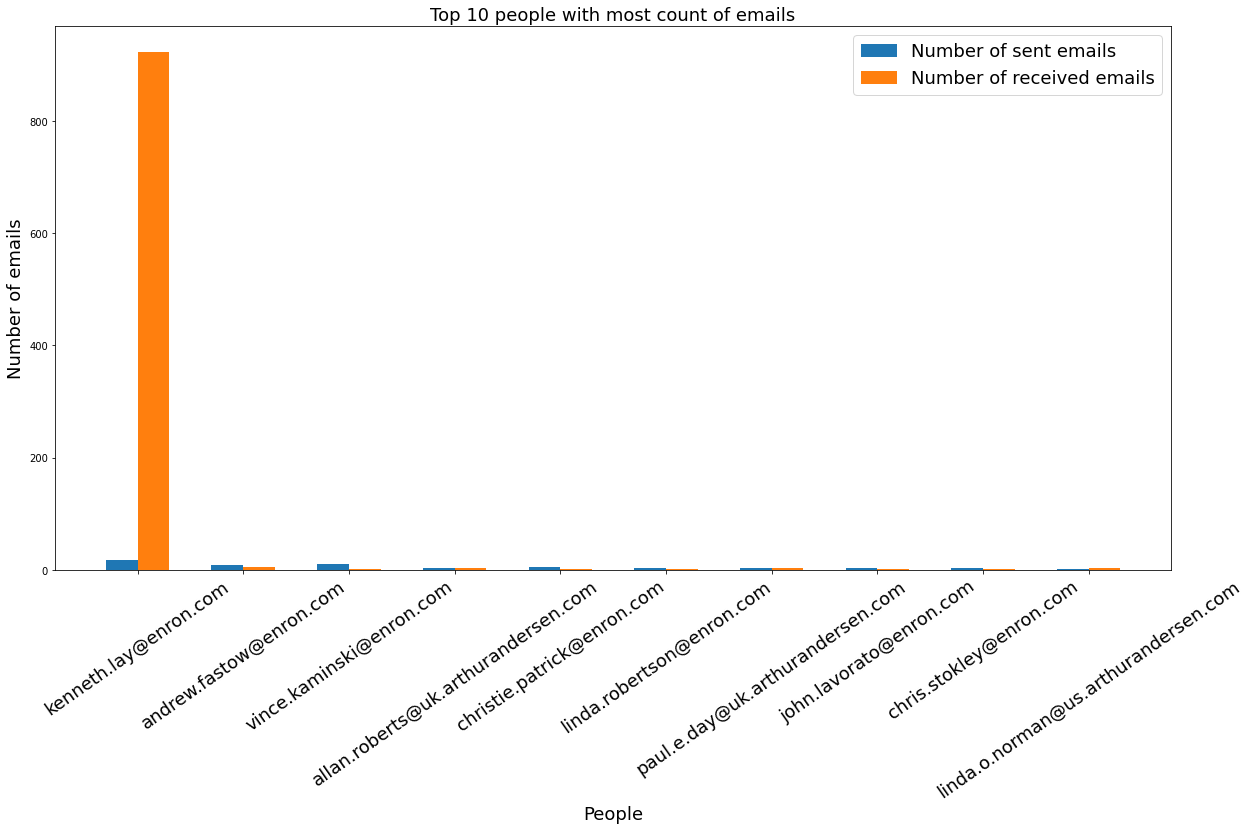

In [ ]:
import matplotlib.pyplot as plt

N = 10

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = (23, 25, 17)
# Specify the values of orange bars (height)
orange_bar = (19, 18, 14)

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(20,10))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, df_all_people['sent'] , width, label='Number of sent emails')
plt.bar(ind + width, df_all_people['received'], width, label='Number of received emails')

plt.xlabel('People', fontsize=18)
plt.ylabel('Number of emails', fontsize=18)
plt.title('Top 10 people with most count of emails', fontsize=18)

# xticks()
plt.xticks(ind + width / 2, ('kenneth.lay@enron.com', 'andrew.fastow@enron.com', 'vince.kaminski@enron.com', 'allan.roberts@uk.arthurandersen.com', 'christie.patrick@enron.com',
                                                     'linda.robertson@enron.com', 'paul.e.day@uk.arthurandersen.com', 'john.lavorato@enron.com', 'chris.stokley@enron.com', 
                             'linda.o.norman@us.arthurandersen.com'), rotation=35, fontsize=18)

# Finding the best position for legends and putting it
plt.legend(loc='best', fontsize=18)
plt.show()

In [ ]:
df_sender_recipient = (new_df.groupby(['senders','recipients']).size().sort_values(ascending=False).reset_index(name='count')).head(10)
df_sender_recipient

,senders,recipients,count
0,steven.kean@enron.com,kenneth.lay@enron.com,29
1,svarga@kudlow.com,kenneth.lay@enron.com,20
2,karen.denne@enron.com,kenneth.lay@enron.com,14
3,terrie.james@enron.com,kenneth.lay@enron.com,13
4,enron_update@concureworkplace.com,kenneth.lay@enron.com,13
5,rob.bradley@enron.com,kenneth.lay@enron.com,13
6,greg.piper@enron.com,kenneth.lay@enron.com,13
7,michael.mann@enron.com,kenneth.lay@enron.com,11
8,j..kean@enron.com,kenneth.lay@enron.com,11
9,lynda.l.phinney@williams.com,kenneth.lay@enron.com,11


Table IV: People with most communication.

Kenneth Lay has received most emails, and Steven Kean has sent the most emails. Also they are the two people with the most communication. This is reasonable since Kenneth Lay is the CEO of Enron, and Steven Kean is the chief of staff.

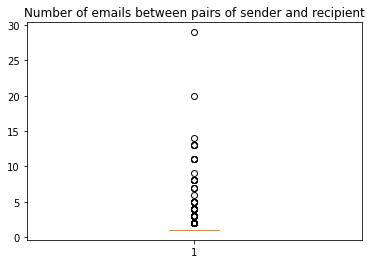

In [ ]:
pairs = new_df[['senders', 'recipients', 'text']].groupby(['senders', 'recipients']).count().reset_index()
plt.boxplot(pairs['text'])
plt.title('Number of emails between pairs of sender and recipient')
plt.show()

In [ ]:
pairs['text'].describe()

count    779.000000
mean       1.587933
std        1.938225
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       29.000000
Name: text, dtype: float64

Table V: Number of emails between pairs of sender and recipient

We grouped all emails by the pair of sender and recipient and counted the total number of email between each pair. From the boxplot, we discovered that most pairs of sender and recipient only connect once and only a small proportion of sender and recipients communicate regularly.

After that, we take a deeper insight into the pairs with regular communications. We take the top pair as an instance to see whether they communicate regularly by email but suddenly stop.


In [ ]:
pairs = pairs.sort_values('text', ascending=False).reset_index()
new_df = new_df.reset_index()

In [ ]:
new_df['pair1'] = 0
for i in range(len(new_df)):
  if new_df['senders'][i] == pairs['senders'][0] and new_df['recipients'][i] == pairs['recipients'][0]:
    new_df['pair1'][i] = 1

In [ ]:
pair1 = new_df[new_df['pair1'] == 1]
pair1 = pair1[['date', 'text']].groupby('date').count().reset_index()

In [ ]:
pair1['yearMonth'] =pair1.date.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m'))
pair1 = pair1[pair1['yearMonth'] != '1979-12']

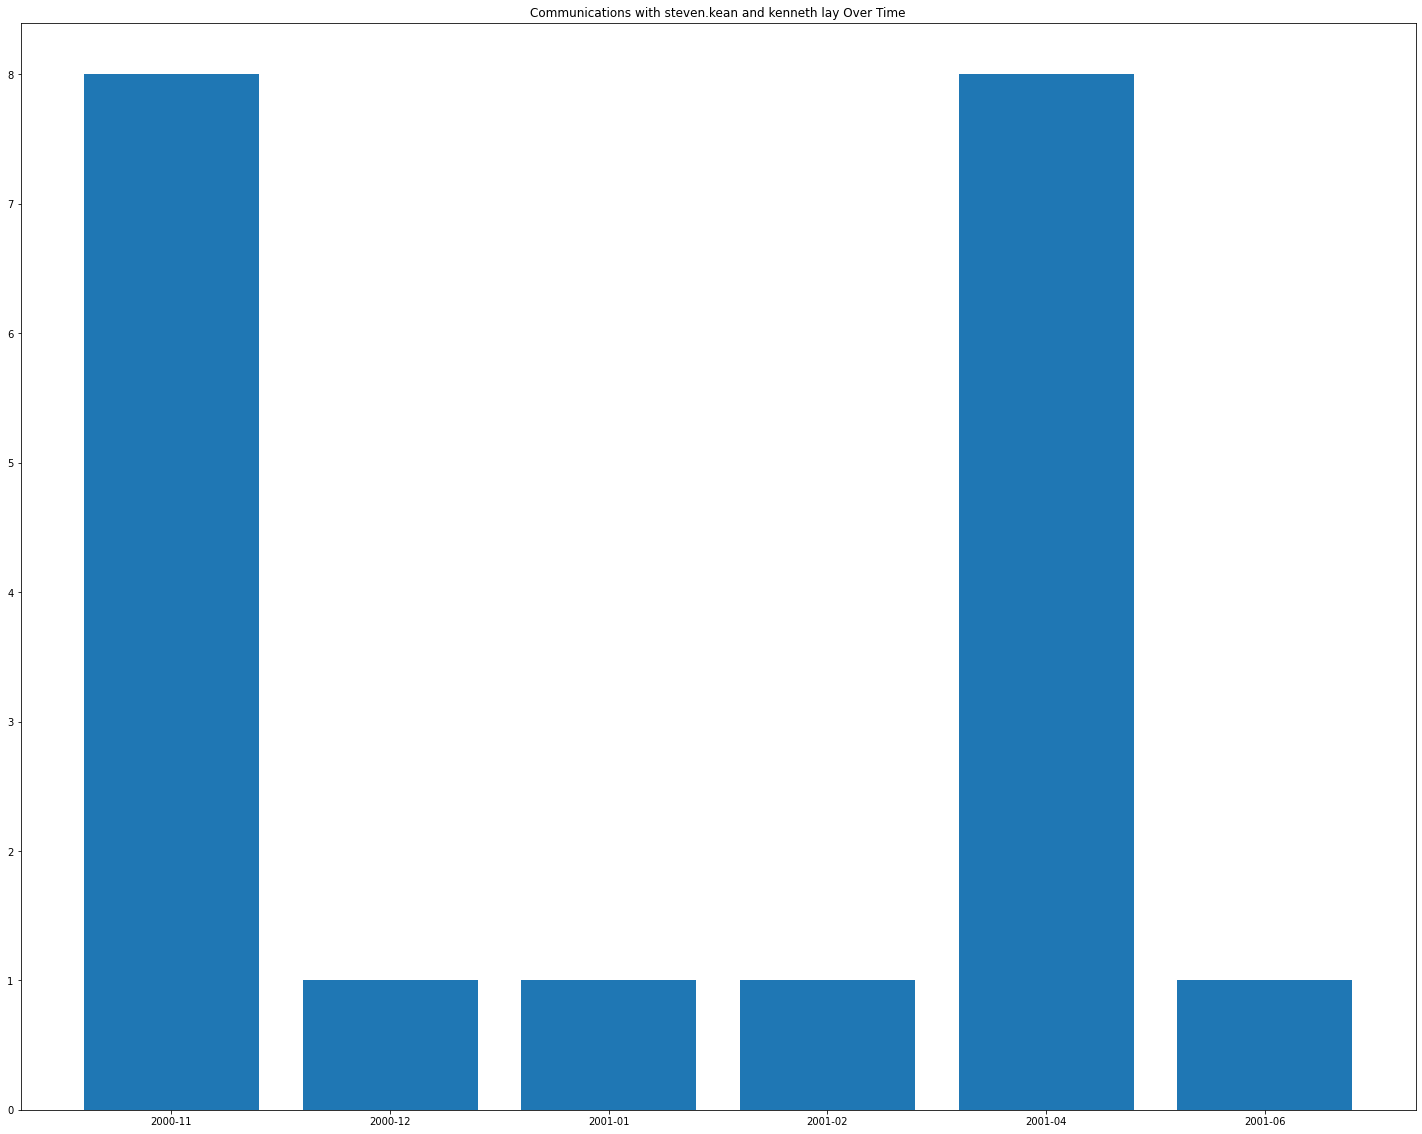

In [ ]:
plt.figure(figsize=(25,20))
plt.title("Communications with steven.kean and kenneth lay Over Time")
plt.bar(x = pair1['yearMonth'], height = pair1['text'])
plt.show()

The figure above demonstrate the number of emails sent between steven.kean and kenneth.lay, the pair who communicate with each other the most frequently, over time. We discover that they continue to communiate between 2000-11 to 2001-06. However, while the communications in 2000-11 and 2001-04 are frequent, the communications in the months between, from 2000-12 to 2001-03 is rare.

In [ ]:
all_pair = new_df[['date', 'text']].groupby('date').count().reset_index()
all_pair['yearMonth'] =all_pair.date.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m'))
all_pair = all_pair[all_pair['yearMonth'] != '1979-12']

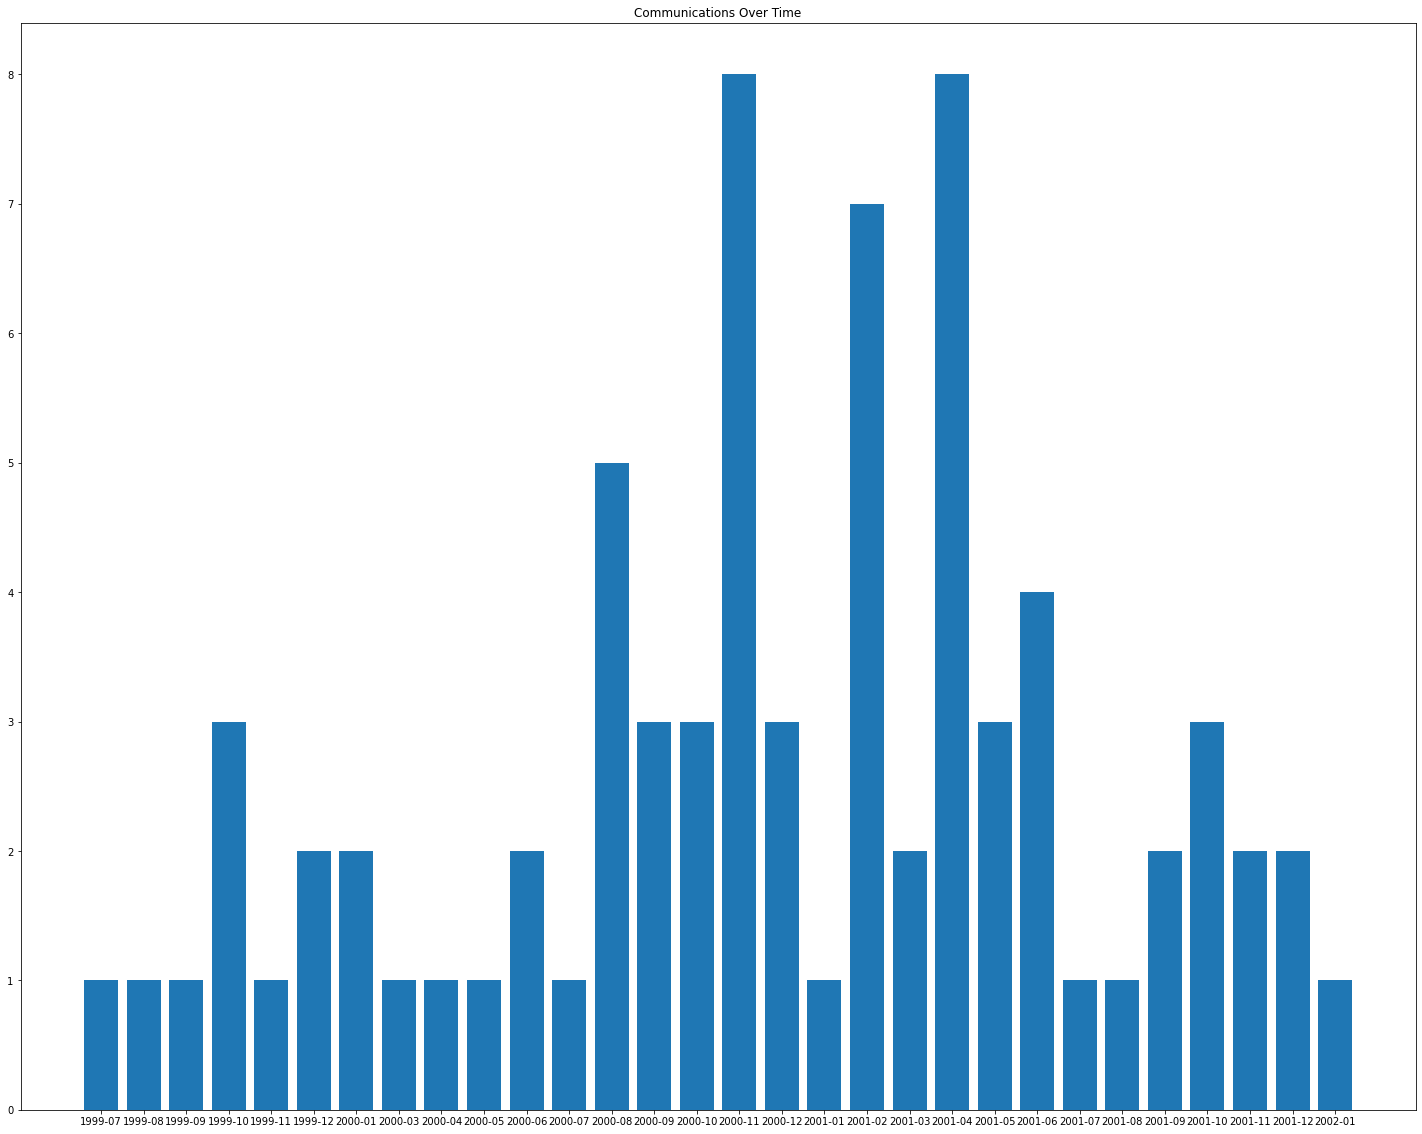

In [ ]:
plt.figure(figsize=(25,20))
plt.title("Communications Over Time")
plt.bar(x = all_pair['yearMonth'], height = all_pair['text'])
plt.show()

Because it is strange the kenneth.lay and steven.kean communicate less frequent in months around 2001-01, we also take a look at all communications overtime.

From the figure above, we discover that while the overall communications between 2000-08 and 2001-06 were frequent, there was only 1 email overall in 2001-01, which is very strange. Therefore, it is suspicious that emails in 2001-01 might be deleted for some unknown reasons, probably associated with the fraud.

## Interaction between companies

In [ ]:
new_df['sender_company'] = new_df['senders'].apply(lambda x: x[x.find("@")+1:x.rfind(".com")])
new_df['recipient_company'] = new_df['recipients'].apply(lambda x: x[x.find("@")+1:x.rfind(".com")])

In [ ]:
sender_company = (new_df.groupby('sender_company').size().sort_values(ascending=False).reset_index(name='count')).head(12)
sender_company = sender_company.drop([2,3])
sender_company = sender_company.reset_index()
sender_company = sender_company.drop(columns=['index'])
sender_company

,sender_company,count
0,enron,708
1,aol,37
2,kudlow,20
3,concureworkplace,13
4,us.arthurandersen,12
5,layfam,11
6,williams,11
7,yale.ed,11
8,lplpi,11
9,cnn,11


Table V: Companies with most communication with Enron

Enron has lots of interaction with companies like Arthur Andersen, and AOL. Arthur Andersen is Enron’s accounting firm, and in 2002, it was found guilty of crimes in the firm's auditing of Enron. And for AOL, there is lots of news between AOL and Enron, for example, like “Enron signs with AOL to sell energy online”, “Enron, IBM, AOL Form Retail Energy Dream Team”. So these firms indeed have close interaction with Enron. And if we further want to have some investigation from other companies, we can focus on these companies.

# Brainstorm a comprehensive list of factors that could affect the recorded data, or the trends your models will capture.

Before building up a model, it is important to notice that there are many factors that could conceivably influence the recorded emails' content and amount in our dataset accidentally or intentionally. Also, some factors may also influence the performance of our NLP model. Here are some of these factors:



*   Emails being deleted.
*   Emails being edited.
*   Important and illegal activities are talked via phones, or face-to-face, not via emails. 
*   Email contents do not contain important information, instead, links and attached files contain important information.
*   People being cced or bcced.
*   Suspicion of future investigation, so they will convey wrong information.
*   People use code words or abbreviation.
*   Misspelling of words.
*   Single person uses multiple email addresses.
*   Email servers are down.
*   Position of the sender and recipient.






# Complementary Sources of Data

Emails can only show part of the information about investigation recommendation and evidence of fraud. So to better conduct an investigation, we also need some complementary sources of data. 

*   Data from other related companies such as Arthur Andersen.
*   Enron's employee records.
*   Enron's transactions with its partnerships.
*   Enron's communication record from other platforms, like call history.
*   Enron's financial report.
*   Interviews of suspected employees.
*   Internal documents of Enron.

# Model Staircase

Here are some approaches we proposed.


*   Topic modeling using LDA(Latent Dirichlet Allocation) (baseline model).
*   Simple keyword search (Variant 1).
*   Topic modeling on emails with negative sentiment scores (Varaint 1). 
*   Run a topic model on the whole corpus using LDA, then see how topic use varies with time (Variant 2).
*   Use Top2Vec (Angelov, D., 2020.) for topic modeling (Variant 3).
*   Use Embedded Topic Model (Dieng, A. B., Ruiz, F. J., & Blei, D. M., 2020.) for topic modeling.
*   Use BERTopic for topic modeling.
*   Use dynamic topic model (Variant 4).
*   Network analysis (Variant 5).







# Baseline Model(LDA: Latent Dirichlet Allocation)

In the baseline model, Latent Dirichlet Allocation is used to do topic modeling. And it generates 25 topics that occur in the emails. However, there are some problems and limitations with this baseline model. For example, LDA uses bag-of-words and ignores syntactic and semantic word relationships. Also, in baseline model, we only look at the key words of the 25 topics without conducting any deeper and further investigation. So in the next few variants, we will provide a detailed overview of the situation and recommendations for who to investigate at what times on what topics. Also, we will use a different model to take syntactic and semantic word relationships into consideration.

In [ ]:
# defining top_k_words from mail body 

def get_stop_words():
    stop = set(stopwords.words('english'))
    
    stop.add("XFrom")
    stop.add("XTo")
    stop.add("Xcc")
    stop.add("Xbcc")
    stop.add("XFolder")
    
    return stop

def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    mails = df['text'].values

    for mail in mails:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', mail)
                            if word.lower() not in stop and len(word) > 2 ])
    topk = counter.most_common(kwords)
    return topk

In [ ]:
# creating dataframe only for those mails received by the co-founder of Enron, Kenneth Lay
cf_df = df[df["recipients"].str.contains("kenneth.lay@enron.com")]

In [ ]:
# tokenizing mail body text so that is useful for topic modeling 
# use regular expression tokenizer to tokenize
tokenizer = RegexpTokenizer(r'\w+')
cf_df['text'] = cf_df['text'].apply(lambda x : tokenizer.tokenize(x))
clean_mails = cf_df['text'] 
clean_mails3 = cf_df

In [ ]:
stop = get_stop_words()
clean_mails2 = clean_mails3
clean_mails2['text'] = clean_mails3['text'].apply(lambda words: [word.lower() for word in words if word.lower() not in stop])

In [ ]:
import jax
import jax.numpy as np
from collections import Counter
c = Counter()


VOCAB = 1000
TOPICS = 25
#DOCUMENT = "documents.txt"
#STOPLIST = "stoplist.txt"
EPOCHS = 50

#clean_mails = clean_mails2

data = []
for l in clean_mails2['text']:
    #tokens = parse(l)
    for t in l:
        c[t] += 1
vocab = {v:i for i, (v, _) in enumerate(c.most_common(VOCAB))}

#vocab is a dict: key is string, value is int from 0 to VOCAB


data = []
doc = []
for i, l in enumerate(clean_mails2['text']):
    tokens = l
    tokens = [t for t in tokens if t in vocab]
    data += [vocab.get(t) for t in tokens]
    doc += [i] * len(tokens)
DOCUMENTS = i + 1

SIZE = len(data)
print("Data Size", SIZE)

# data is total number of tokens in entire corpus, each spot is an int saying which token
# doc is total number of tokens in entire corpus, each spot is an int saying which doc


# Need:
# vocab dict word -> index
# data

Data Size 141767


In [ ]:
# Create tables
key = jax.random.PRNGKey(0)
data = np.array(data, dtype=np.int32)
docs = np.array(doc, dtype=np.int32)
topic_token = jax.random.randint(key, (SIZE,), 0, TOPICS, dtype=np.int32)

topic_word = jax.ops.index_add(np.zeros((TOPICS, VOCAB), dtype=np.int32), 
                               jax.ops.index[topic_token.reshape(-1), data.reshape(-1)], 1)
topic_document = jax.ops.index_add(np.zeros((DOCUMENTS, TOPICS), dtype=np.int32), 
                                   jax.ops.index[docs, topic_token], 1)
tokens_doc = np.bincount(docs, length=DOCUMENTS)


# Main code
ALPHA, BETA = 0.1, 0.01


def token_loop(state, scanned):
    topic_word, topic_document, topic_count = state
    topic_token, data, doc, key = scanned

    local_tw = topic_word[:, data].at[topic_token].add(-1)
    local_td = topic_document[doc].at[topic_token].add(-1)
    local_tc = topic_count.at[topic_token].add(-1)

    # Resample
    dist = ((local_tw + BETA) / (local_tc + VOCAB * BETA)) \
           * ((local_td + ALPHA) / (tokens_doc[doc] + TOPICS * ALPHA))
    new_topic = jax.random.categorical(key, np.log(dist))

    def update(_):
        return (topic_word.at[new_topic, data].add(1).at[topic_token, data].add(-1),
                topic_document.at[doc, new_topic].add(1).at[doc, topic_token].add(-1),
                topic_count.at[new_topic].add(1).at[topic_token].add(-1),
        )
    
    return jax.lax.cond((new_topic != topic_token),
                        update,
                        lambda _ : (topic_word, topic_document, topic_count), None
    ), (new_topic, None, None, None)    
    

@jax.jit
def mcmc(state):
    topic_count, topic_word, topic_document, topic_token, key = state
    keys = jax.random.split(key, SIZE + 1)
    (topic_word, topic_document, topic_count), (topic_token, _, _, _) = \
      jax.lax.scan(token_loop, 
                (topic_word, topic_document, topic_count), 
                (topic_token, data, docs, keys[1:]))
    return topic_count, topic_word, topic_document, topic_token, keys[0]

def run(topic_word, topic_document, topic_token):
    key = jax.random.PRNGKey(1)
    topic_count = topic_word.sum(-1)
    for i in range(EPOCHS):
        (topic_count, topic_word, topic_document, topic_token, key) =  \
          mcmc((topic_count, topic_word, topic_document, topic_token, key))
    return topic_word, topic_document, topic_token
topic_word, topic_document, topic_token = run(topic_word, topic_document, topic_token) 

In [ ]:
# Print out
rev = {v:k for k,v in vocab.items()}
out = topic_word / topic_word.sum(-1, keepdims=True)
for i in range(TOPICS):
    print("TOPIC", i, [rev[int(x)] for x in reversed(np.argsort(out[i])[-5:])])

TOPIC 0 ['enron', 'india', 'deal', 'would', 'first']
TOPIC 1 ['enron', 'call', 'xfilename', 'xorigin', 'list']
TOPIC 2 ['letter', 'please', 'call', 'arena', 'send']
TOPIC 3 ['communications', 'communicationsenron', 'ken', 'business', 'mark']
TOPIC 4 ['cable', 'vod', 'service', 'new', 'million']
TOPIC 5 ['houston', 'us', 'business', 'international', 'time']
TOPIC 6 ['business', 'contract', 'concerns', 'february', 'call']
TOPIC 7 ['xorigin', 'xfilename', 'layk', 'fund', 'provide']
TOPIC 8 ['xfilename', 'xorigin', 'layk', 'conference', 'please']
TOPIC 9 ['email', 'message', 'please', 'information', 'october']
TOPIC 10 ['ferc', 'immelt', 'ge', 'gas', 'said']
TOPIC 11 ['meeting', 'best', 'ken', 'time', 'draft']
TOPIC 12 ['us', 'know', 'god', 'lay', 'family']
TOPIC 13 ['enron', 'would', 'know', 'ken', 'time']
TOPIC 14 ['time', 'cost', 'price', 'must', 'real']
TOPIC 15 ['energy', 'gas', 'power', 'government', 'vice']
TOPIC 16 ['tt', 'j', 'pm', 'steven', 'jeff']
TOPIC 17 ['see', 'back', 'get',

# Variant 1: Simple Keyword Search
## Subvariant: Search by Keyword

Firstly, the easiest and the most straight-forward appraoch to find evidence of fraud is to search for phrases like "police", "fruad", and "investigation", followed by an expensive and time-consuming manual review process to determine which emails are responsive for the fraud.

In this part, we simply searched three keywords: `police`, `fraud`, and `investiation`, that might be associated with the fraud and print out related emails to demonstrate some examples of this approach.

In [ ]:
police = new_df[new_df["text"].str.contains("police")]
for index, row in police.iterrows():
  print("Sender: {}".format(row['senders']))
  print("Date: {}".format(row['date']))
  print("Subject: {}".format(row['subject']))
  print("Text: {}".format(row['text']))
  print()

Sender:  j..kean@enron.com
Date: 2001-11-14 12:35:16-08:00
Subject: nan
Text: XOrigin KeanS XFileName SKEAN NonPrivilegedpst  Some background information for the meeting with Mayor Brown  Brown won  of the vote to Sanchez  and is now in a run off with Sanchez  Sue Waldens perspective not surprisingly is that Brown will win and that campaign polls show him ahead among likely voters  African American turnout in the election was lower than expected but an active getoutthevote campaign could turn that around Enron has supported the mayor with a  contribution  I would not recommend a further commitment under the current circumstances If you want to discuss some of the positive accomplishments of his administration you could Congratulate him on passage of his version of the light rail proposition Compliment him on how he has responded to security issues since Sept  and his handling of flood relief You should know that the Houston police were extremely helpful and responsive when we asked for

In [ ]:
fraud = new_df[new_df["text"].str.contains("fraud")]
for index, row in fraud.iterrows():
  print("Sender: {}".format(row['senders']))
  print("Date: {}".format(row['date']))
  print("Subject: {}".format(row['subject']))
  print("Text: {}".format(row['text']))
  print()

Sender:  billy.lemmons@enron.com
Date: 2002-01-10 12:10:39-08:00
Subject: Accounting Article From Fortune Magazine
Text: Ken  Beth suggested that I forward a copy of this article to you  Ive highligh ted some relevant points for your convenience  Regards Billy    ACCOUNTING IN CRISIS One Plus One Makes What The accounting profession had a credibility problem before Enron Now it ha s a crisis FORTUNE Monday January   Where were the auditors People ask that question after every corporate col lapse and lately theyve been asking it with disturbing frequency At Wast e Management Sunbeam Rite Aid Xerox and Lucent major accounting firms  either missed or ignored serious problems The number of public companies t hat have corrected or restated earnings since  has doubled to  acco rding to a study by Big Five accounting firm Arthur Andersen Now followin g the stunning bankruptcy of Andersens own client Enron that questionwh ere were the auditorshas become a deafening refrain I believe that the r

In [ ]:
investigation = new_df[new_df["text"].str.contains("investigation")]
for index, row in investigation.iterrows():
  print("Sender: {}".format(row['senders']))
  print("Date: {}".format(row['date']))
  print("Subject: {}".format(row['subject']))
  print("Text: {}".format(row['text']))
  print()

Sender:  kenneth.lay@enron.com
Date: 2001-09-25 11:39:46-07:00
Subject: RE: Media Reports
Text: Hasan  I fully understand and agree with your comments  Unfortunately I did not see the Travel Secruity Update email before it was sent out  We will do better  Ken   Original Message From tKedwaii Hasan   SenttFriday September    AM TotLay Kenneth SubjecttRE Media Reports  Sir I read your note with great deal of interest and care  I was pleasantly surprised to see that this email was devoid of any stereotypical remarks that are so prevalent in the mass media today  Unfortunately such is not the case with other communications being sent out on behalf of Enron Corp  A case in point is the corporate security email titled Travel Security Update that was send out yesterday  In this email reaction to possible US military retaliation has been tied to extremist Islamic violence  Truth of the matter is that any reaction to the US military action could be because of extreme nationalism most likely to 

## Subvariant: Sentiment Score
Next, we focused on the sentiment score, especially the negativity socre. We wanted to see if the emails with highest negativity scores would have different topics, and if these topics could imply any signs of fraud. After we calculated the sentiment scores, we extracted the emails with top 100 negativity scores, and we trained a LDA on those emails to see their topics.

In [ ]:
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
stop_words = stopwords.words('english')
cf_df2['text_without_stopwords'] = cf_df2['text'].apply\
(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
sia = SIA()
cf_df2['Positivity'] = cf_df2['text_without_stopwords'].apply\
(lambda Text: pd.Series(sia.polarity_scores(Text)['pos']))
cf_df2['Negativity'] = cf_df2['text_without_stopwords'].apply\
(lambda Text: pd.Series(sia.polarity_scores(Text)['neg']))
cf_df2['Neutrality'] = cf_df2['text_without_stopwords'].apply\
(lambda Text: pd.Series(sia.polarity_scores(Text)['neu']))

In [ ]:
cf_df2 = cf_df2.sort_values(by = 'Negativity', ascending=False)

In [ ]:
cf_df2 = cf_df2.head(100)

In [ ]:
co_founder_top_words2 = getTopKWords(cf_df2, 200)
corp2 = []
for i, j in co_founder_top_words2:
    corp2.append(i)
corp2 = [word.split() for word in corp2]

In [ ]:
# creating corpora of the relevant keywords
id2word2 = corpora.Dictionary(corp2)

# tokenizing mail body text so that is useful for topic modeling 
# use regular expression tokenizer to tokenize
tokenizer = RegexpTokenizer(r'\w+')
cf_df2['text'] = cf_df2['text'].apply(lambda x : tokenizer.tokenize(x))
new_clean_mails = cf_df2['text'] 
new_clean_mails3 = cf_df2

In [ ]:
stop = get_stop_words()
new_clean_mails2 = new_clean_mails3
new_clean_mails2['text'] = new_clean_mails3['text'].apply(lambda words: [word.lower() for word in words if word.lower() not in stop])

In [ ]:
new_clean_mails = new_clean_mails2['text']
corpus2 = [id2word2.doc2bow(text) for text in new_clean_mails]

In [ ]:
# finding tf_idf scores with corpus
tfidf2 = models.TfidfModel(corpus2)
tf_corpus2 = tfidf2[corpus2]

In [ ]:
# calling LDA model
# we are modeling for 5 topics
LDA_gen = ldamodel.LdaModel(corpus=tf_corpus2,
                                           id2word=id2word2,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=3,
                                           passes=3,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [ ]:
LDA_gen.print_topics(num_words=10) 

[(0,
  '0.056*"would" + 0.055*"hope" + 0.047*"people" + 0.041*"know" + 0.038*"employees" + 0.034*"think" + 0.032*"many" + 0.027*"houston" + 0.024*"things" + 0.019*"could"'),
 (1,
  '0.090*"pay" + 0.068*"information" + 0.059*"due" + 0.041*"since" + 0.037*"left" + 0.033*"business" + 0.029*"deal" + 0.025*"office" + 0.024*"enrons" + 0.023*"also"'),
 (2,
  '0.060*"arena" + 0.046*"lord" + 0.043*"eckels" + 0.039*"agreement" + 0.035*"mayor" + 0.035*"sports" + 0.031*"judge" + 0.031*"chronicle" + 0.027*"authority" + 0.026*"look"'),
 (3,
  '0.044*"enron" + 0.034*"lay" + 0.031*"questions" + 0.029*"former" + 0.029*"two" + 0.025*"stock" + 0.024*"company" + 0.023*"like" + 0.021*"time" + 0.020*"wanted"'),
 (4,
  '0.029*"good" + 0.025*"thank" + 0.025*"sent" + 0.024*"robertson" + 0.022*"job" + 0.021*"money" + 0.021*"best" + 0.021*"made" + 0.020*"make" + 0.019*"layk"')]

For each of the topic, we definitely saw some words that might involve in the fraud, such as "committee", "management", "agreement", "judge", "authority", and "stock". These words could imply false manipulation, legal process, and market impact. Since our focus was to correcely indentify fraud, sentiment score could be associated with possible and thus became a metric to determine fraud.

# Variant 2: How Topic Varies By Time and Person

In this variant, we will still run a topic model on the whole corpus using the LDA model with 25 topics as the baseline model. But we will further see what topic each email belongs to, and then visualize how the topic use varies with time.

In [ ]:
# topic of each document
topic_id = topic_document.argmax(axis=1)

In [ ]:
clean_mails2['id'] = clean_mails2.index

In [ ]:
doc_topic = pd.DataFrame({'id': clean_mails2['id'], 'topic_id': topic_id}, columns=["id", "topic_id"])

In [ ]:
cf_df = df[df["recipients"].str.contains("kenneth.lay@enron.com")]
cf_df['id'] = cf_df.index

In [ ]:
# merge original dataset with the one with topic id
new_cd_df = cf_df.merge(doc_topic, left_on='id', right_on='id')

In [ ]:
# normalize datetime
new_cd_df['specific_month'] = new_cd_df['date'].apply(lambda x: x[:7])
new_cd_df['specific_month'] = pd.to_datetime(new_cd_df['specific_month'])
new_cd_df = new_cd_df[new_cd_df['specific_month'].dt.year >= 1999]

In [ ]:
df2 = new_cd_df.groupby(['specific_month', 'topic_id'])['id'].count().unstack().fillna(0)

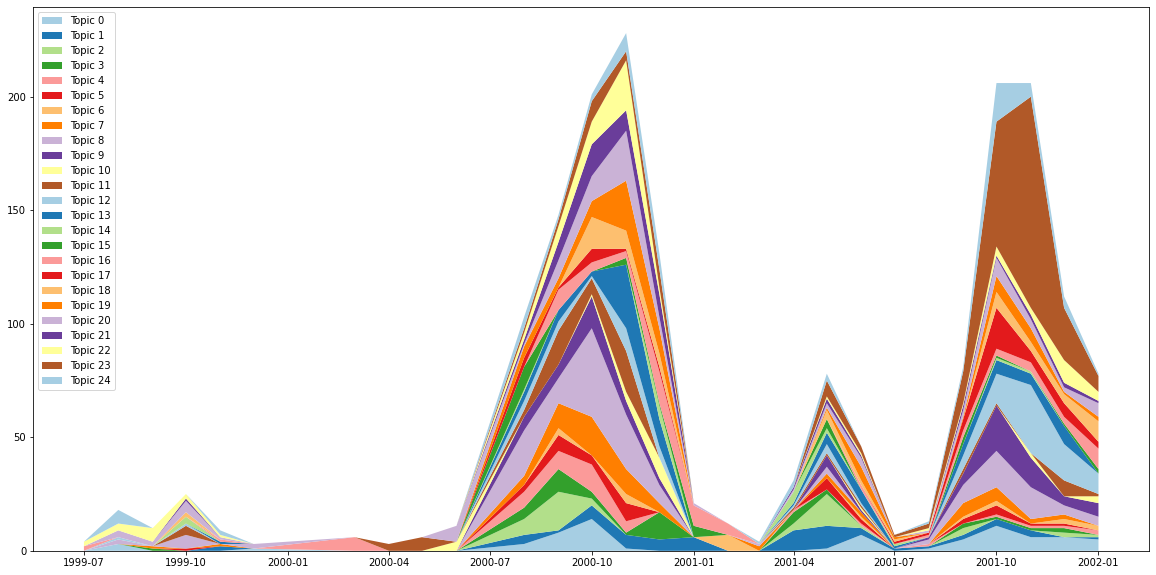

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
x=df2.index
y = []
for i in range(25):
  y.append(df2[i])
col = sns.color_palette("Paired", 24)
labels = ["Topic 0", "Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5", "Topic 6", "Topic 7", "Topic 8",
          "Topic 9", "Topic 10", "Topic 11", "Topic 12", "Topic 13", "Topic 14", "Topic 15", "Topic 16", "Topic 17",
          "Topic 18", "Topic 19", "Topic 20", "Topic 21", "Topic 22", "Topic 23", "Topic 24"]

# Stacked area chart.
plt.figure(figsize=(20,10))
plt.stackplot(x, y[0], y[1], y[2], y[3], y[4], y[5], y[6], y[7], 
              y[8], y[9], y[10], y[11], y[12], y[13], y[14], y[15],
              y[16], y[17], y[18], y[19], y[20], y[21], y[22], y[23], y[24], colors = col, labels = labels)
plt.legend(loc='upper left')
plt.show()

From the stacked area chart above, it is obvious that topic use varies with the time, and there are some time periods that a specific topic is widely used. For example, there are three peaks of number of emails sent, one from 2000-06 to 2001-01, one from 2001-03 to 2001-07, and one from 2001-08 to 2002-01, however, in the first peak(2000-06 to 2001-01), the topics are relatively evenly distributed, and in the second small peak(2001-03 to 2001-07), topic 0, 1, 2 are the main topics, and in the last peak(2001-08 to 2002-01), topic 23 is the main topic. In addition, there are some other obvious changes in topics:

*   Topic 22 occurred more often in the first peak(2000-06 to 2001-01) compared to other time.
*   Topic 23 has occupied a large proportion of all email topics in the third peak(2001-08 to 2002-01) while emails that are topic 23 are very few in other time.
*   Compared to other months, topic 10 occurred more often in the first peak(2000-06 to 2001-01).
*   Compared to other months, topic 12 and 24 occurred more often in the third peak(2001-08 to 2002-01).



We will take a look at some of these topics changes, and see if there are any specific events behind these topics.

First, if we focus on topic 10, which occurred more often in the first peak(2000-06 to 2001-01), we can see 'gas' is a keyword for this topic. And there are many emails in topic 10 talking about gas, for example 


*   Attached are several documents which capture our positions in reaction to  power and gas pricing particularly in California....The gas paper was prepared in September and needs updating but I have included it as well...
*   It only took three years for them to get it right...The stricter consents policy moratorium on gas-fired generation has been lifted per this announcement...

And many emails in topic 10 talk about California and gas. It is worth noticing, and we searched online and found that 'California', 'gas' is closely related to 'Enron'. The 2000–01 California electricity crisis, also known as the Western U.S. energy crisis of 2000 and 2001, was a situation in which the U.S. state of California had a shortage of electricity supply caused by market manipulations and capped retail electricity prices. California had an installed generating capacity of 45 GW. At the time of the blackouts, demand was 28 GW. A demand-supply gap was created by energy companies, mainly Enron, to create an artificial shortage. (https://en.wikipedia.org/wiki/2000–01_California_electricity_crisis).

And this California electricity crisis is from April 2000, to the start of 2001, which is quite similar as the time of our peak 1(2000-06 to 2001-01).


Then, for topic 4, among all the three peaks, only peak 1 (2000-06 to 2001-01) contains a relatively large proportion of topic 4 emails, and peak 2 and 3 contains almost no topic 4 emails. And "vod" is one of these keywords of topic 4. In 1999, Blockbuster teamed up with Enron to create a video-on-demand(VOD) service and they ended up partnership in early 2001. That might be one of the explanation why topic 4 rarely occurred after 2001-01 in our model. 

So the topic use changes with time, and there are some specific events behind some topics. 

# Variant 3: A Different Model: Top2Vec

For this variant, we are going to use embedding and clustering. Since one problem with LDA is that it uses bag-of-words and ignores syntactic and semantic word relationships. Even if it uses stemming and lemmatization, it still can not recognize similar words that do not share a word stem, for example, large and big. So in this variant, we use the model called Top2Vec (Angelov, D., 2020.), which uses word2vec to generate word embeddings. 

Top2Vec first generates a semantic space by applying word2vec and doc2vec to generate word and document embeddings. Similar words and documents are close together in the semantic space. Then it uses UMAP and HDBSCAN to lower the dimension and do clustering. So documents with the same topics will be clustered together, and word vectors that are closest to a topic vector are the most representative of the topic.

In [ ]:
!pip install -q gensim
!pip install -q pynndescent>=0.4
!pip install -q umap-learn
!pip install -q hdbscan
!pip install -q wordcloud
!pip install -q tensorflow
!pip install -q tensorflow_hub
!pip install -q tensorflow_text
!pip install -q torch
!pip install -q sentence_transformers
!pip install -q hnswlib
!pip install -q joblib<1.0.0

In [ ]:
!pip install -q top2vec[sentence_transformers]

In [ ]:
from copy import deepcopy
from top2vec import Top2Vec

In [ ]:
cf_df = df[df["recipients"].str.contains("kenneth.lay@enron.com")]

In [ ]:
docs = list(cf_df.loc[:, "text"].values)

In [ ]:
model = Top2Vec(docs, embedding_model='universal-sentence-encoder')

In [ ]:
num_topic = model.get_num_topics()

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(num_topic)

for i in range(len(topic_words)):
    topic_word = topic_words[i]
    word_score = word_scores[i]
    print("Topic: "+str(i))
    for j in range(30):
      print(topic_word[j]+": "+str(word_score[j]))
    print("\n")

Topic: 0
enron: 0.45388284
sincerely: 0.24727291
corp: 0.2301839
corporation: 0.22238864
ceo: 0.21980532
executives: 0.2077232
merger: 0.19914153
corporate: 0.19763461
pge: 0.19408052
integrity: 0.19102672
firm: 0.18957809
creditors: 0.18852708
kenneth: 0.18804622
investors: 0.18701327
affairs: 0.1866499
hr: 0.18576732
regards: 0.18493825
transaction: 0.17470804
venture: 0.17377639
managing: 0.17092115
executive: 0.16913609
employees: 0.16869622
re: 0.16735111
management: 0.16628933
manager: 0.16601479
risk: 0.16487938
committed: 0.16161439
inc: 0.15955892
equity: 0.15838847
stock: 0.15599176


Topic: 1
conference: 0.28345132
meetings: 0.2613675
meeting: 0.2511409
keynote: 0.22536683
participants: 0.2128766
committee: 0.21144038
secretary: 0.20955731
presentation: 0.19099352
agreement: 0.189361
event: 0.18868282
pge: 0.18699324
pm: 0.18054715
speaker: 0.1789936
discussed: 0.17149311
sincerely: 0.17014
session: 0.16683556
mayor: 0.16501251
participate: 0.16468361
leadership: 0.16181254


By applying Top2Vec to our emails, we get 31 topics. By simply looking at the top few words, it’s hard to get an idea on its topic, so I further looked at the documents that are clustered to be topic 0, 1, and 2. Here are 3 examples of each of them.

**Topic 0**

Example 1: Mr Lay  I would like to take this opportunity to thank you from the bottom of my heart for all the hard work you are trying to do and continue to try to do…Know that there are  still many at Enron who admire the enormity of what you have done for energy markets in the United States…

Example 2: Ken,  I just wanted to say thanks for all that you and Enron have done for me. I know you trusted people close to you and they let you down for that. I’m sorry  I have always believed in you and what you stand for…

Example 3: Good evening Mr Lay, I just wanted to give you a positive note on my behalf.  I really don’t know if you will read this but if you do I wish you all the best with Enron. I don’t know if I’m one of those employees who will be laid off but on the good side of things  I respect you profoundly...

And it is clear that topic 0 is about showing gratitude and belief in Kenneth Lay after leaving the jobs.

**Topic 1**

Example 1: ...Here is the background on a  possible acquisition that we have brought up with them. Enron Metals is very interested in pursuing further discussions  with Atlantic Copper on the acquisition of their smelter in Spain. Estimated  capital would be US Million...

Example 2: ...i was one the initial companies contacted by Enron Net Works ENW for the  EnronOnline commercial discussion. The focus of the Enroni discussion earlier this year was a complete sale of the software asset that drives EnronOnline to i…

Example 3: ...We are currently pursuing two important Q transactions with Sysco an electricity supply contract for their Texas facilities and a demand side management contract for all of their facilities. We had planned to close the Texas supply transaction today. However in a phone conversation I had this morning with Syscos Director of Procurement Terry Taylor, I was informed that Syscos CEO Charles Cotros has instructed Mr Taylor not to enter into any further transactions with us until Enron’s financial picture clears up...

Topic 1 is about business, since from these emails, there are key words like acquisition, sale and contract.

**Topic 2**

Example 1: ...Dean of the UT School of Engineering tells me that he will be in Houston on November and would like to meet with you. I realize that your schedule is overflowing these days however should time permit the Dean would sincerely appreciate...

Example 2: ...In reply to your request for Dr Lay to speak, he has asked that I reply to you with the following message. Advise that the date just doesn’t work because of our Managers Conference but on a different date either I or one of my officers could probably participate…
 
Example 3: ...May I use you as a reference? Let me know if this meets with your approval. I enjoyed seeing you and your family at the convention...


Topic 2 is about making an appointment with Kenneth Lay. For example, the first email is an appointment between Lay and Dean of UT school of engineering. Second one is also for appointment arrangement.

So Top2Vec has actually given much information about the topics, and since topic 0 is about showing gratitude and personal emotion to Kenneth Lay, and little useful information is contained, so if time is limited, we can temporarily ignore emails that are topic 0. And since topic 1 is about business, we can further take a deeper investigation on these emails to see evidence of fraud. And topic 2 is about some personal relationships and appointments with Kenneth Lay, so we can focus on emails in topic 2 to see the network relationship with Kenneth Lay.

# Variant 4: Dynamic Topic Model

The dynamic topic model extends the idea of the orginal LDA to allow topic representations to evolve over fixed time intervals such as years. Since the create time of the emails ranges from 1979 to 2002, with such a large time difference, we want to see if the topics change over time. The generative process of LDA almost remains the same, except for that the overall topic distribution and the term distribution for each topic differ depending on the time slice.

Our implementation was based on the Lda Sequence model, inspired by David M. Blei, John D. Lafferty: “Dynamic Topic Models”, which is a pure Python implementation of the original dynamic topic model. We used this implementation because the code will be easier to understand.



The codes below are the pre-processing of the data. Simply speaking, we rearranged the dataset in a ascending year order, tokenized the emails, and got a bag of the top 100 words as the corpus. The reason we shrinked our corpus was that the DTM took a great amount of time processing, and our topic would still be representative.

In [ ]:
enron = pd.read_csv("enron_top_exe_mails.csv")
df = pd.DataFrame(enron)
df = df.drop("Unnamed: 0", axis=1)

In [ ]:
# applying all defined functions 
df['senders'] = df['senders'].apply(lambda x : remove_from(x))

df['recipients'] = df['recipients'].apply(lambda x : remove_to(x))

df['text'] = df['text'].apply(lambda x : remove_obj(x))

df['text'] = df['text'].apply(lambda x : remove_punct(x)) 

df['text'] = df['text'].apply(lambda x : remove_numbers(x))

In [ ]:
df['date'] = pd.to_datetime(df['date'], utc=True)
df['year'] = df['date'].dt.year

In [ ]:
df = df.sort_values(by=['date'], ignore_index=True)

In [ ]:
# defining top_k_words from mail body 

def get_stop_words():
    stop = set(stopwords.words('english'))
    
    stop.add("XFrom")
    stop.add("XTo")
    stop.add("Xcc")
    stop.add("Xbcc")
    stop.add("XFolder")
    
    return stop

def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    mails = df['text'].values

    for mail in mails:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', mail)
                            if word.lower() not in stop and len(word) > 2 ])
    topk = counter.most_common(kwords)
    return topk

In [ ]:
# creating dataframe only for those mails received by the co-founder of Enron, Kenneth Lay
cf_df = df[df["recipients"].str.contains("kenneth.lay@enron.com")]
cf_df = cf_df.reset_index()

In [ ]:
pd.value_counts(cf_df['year']).sort_index()

1980      4
1999     69
2000    837
2001    817
2002     78
Name: year, dtype: int64

In [ ]:
# finding top 100 words used in the mails received by kenneth 
co_founder_top_words = getTopKWords(cf_df, 100)

In [ ]:
# creating dictionary of relevant words
# we are using top 100 words from the mails received by co-founder
corp = []
for i, j in co_founder_top_words:
    corp.append(i)
corp = [word.split() for word in corp]   # converting individual token (useful for creating gensim dicionary)

In [ ]:
# creating corpora of the relevant keywords
id2word = corpora.Dictionary(corp)

In [ ]:
# tokenizing mail body text so that is useful for topic modeling 
# use regular expression tokenizer to tokenize
tokenizer = RegexpTokenizer(r'\w+')
new_df = cf_df.copy()
new_df['text'] = new_df['text'].apply(lambda x : tokenizer.tokenize(x))
clean_mails = new_df['text'] 
clean_mails3 = new_df

In [ ]:
print(clean_mails3['text'])
stop = get_stop_words()
clean_mails2 = clean_mails3
clean_mails2['text'] = clean_mails3['text'].apply(lambda words: [word.lower() for word in words if word.lower() not in stop])

0       [Xbcc, XFolder, StevenKeanDecNotes, FoldersAll...
1       [Xbcc, XFolder, StevenKeanJuneNotes, FoldersDi...
2       [Xbcc, XFolder, StevenKeanDecNotes, FoldersCal...
3       [Xbcc, XFolder, StevenKeanDecNotes, FoldersArc...
4       [XOrigin, TaylorM, XFileName, mtaylornsf, Here...
                              ...                        
1800    [XOrigin, LayK, XFileName, klay, NonPrivileged...
1801    [Dear, Uncle, Ken, and, Aunt, Linda, Hi, Im, s...
1802    [Dear, Ken, Second, I, want, to, give, you, ah...
1803    [An, anonymous, visitor, stopped, by, Advicebo...
1804    [I, would, very, much, like, to, catch, up, wi...
Name: text, Length: 1805, dtype: object


In [ ]:
clean_mails = clean_mails2['text']
# creating corpus with term document frequency of the abstracts
corpus = [id2word.doc2bow(text) for text in clean_mails]

In [ ]:
# finding tf_idf scores with corpus
tfidf = models.TfidfModel(corpus)
tf_corpus = tfidf[corpus]

In [ ]:
# setting up our imports

from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
import numpy
from gensim.matutils import hellinger

In [ ]:
time_slice = [4, 69, 837, 894, 78]

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=tf_corpus, id2word=id2word, time_slice=time_slice, num_topics=5)
                                      

In [ ]:
dates = {0: 1980, 1: 1999, 2: 2000, 3: 2001, 4: 2002}
data = {}
for i in range(5):
  topics = ldaseq.print_topics(time=i)
  data[dates[i]] = topics

In [ ]:
for i in range(5):
  print('Topic %d' % i)
  for year in [1980, 1999, 2000, 2001, 2002]:
    print(year)
    for word in data[year][i]:
      print("{}: {}".format(word[0], word[1]))
  print()

Topic 0
1980
enron: 0.041216765206703136
employees: 0.03314224624970701
company: 0.025730530800971825
know: 0.02458285001196428
would: 0.02326984443265596
many: 0.020423275744552365
work: 0.020205143874594985
people: 0.019667767972487028
great: 0.019403467725474615
time: 0.01912130216763315
like: 0.016951217705578444
business: 0.016910170558921883
get: 0.01675758965705928
going: 0.01668020951163598
want: 0.016544387182414137
back: 0.016481097705148297
thank: 0.016395978776064486
believe: 0.016101818434892577
years: 0.01603357642737179
good: 0.015740870723144413
1999
enron: 0.041343467527978316
employees: 0.03317436711435499
company: 0.025755090037503682
know: 0.02461393271014421
would: 0.02325544098423073
many: 0.020422157560984106
work: 0.0202383616517016
people: 0.019695891119724585
great: 0.01942185614908927
time: 0.01913494848355509
like: 0.016973962226531938
business: 0.016911762929504658
get: 0.01675601814856281
going: 0.016687804753370776
want: 0.016557822145215232
back: 0.01649

It's not hard to summarize each topic from the top 10 words. Here are some guessed summary of each of the topic.
* Topic 0: Show gratitude to Kenneth
* Topic 1: Emails about meeting time, or meeting procedures
* Topic 2: Market and business
* Topic 3: Tell some information to Kenneth
* Topic 4: Show gratitude for creating such working environment in the farewell email




Next, we want to take a closer look of one of the email samples to see if its content matches the results of our topic. The email I chose to examine is the 223th email (my favourite number).

In [ ]:
doc = ldaseq.doc_topics(223) 
print(doc)

[0.00218503 0.00218503 0.00218503 0.99125989 0.00218503]


In [ ]:
# to check Document - Topic proportions, use `doc-topics`
words = [id2word[word_id] for word_id, count in tf_corpus[223]]
print (words)

['enron', 'ken', 'know', 'call', 'thank', 'message', 'thanks', 'let', 'john', 'fax']


In [ ]:
cf_df['text'][223]

' Ken  Fernley Dison Enron Europe left a message for me to call regarding real estate needs  Thanks for setting me up  Ill let you know how it goes  Thank you  John  John B Poston Poston Yoder Commercial Real Estate  N Central Expwy Suite  Dallas TX    direct  fax johnpostonpostonyodercom'

In [ ]:
cf_df['year'][223]

2000

The result of the topic model suggested that the 223th email should fall into topic 3, telling some information to Kenneth, because it has a probability of 0.9913. When we look at the original passage of the 223th email, we can say that it asked Kenneth to call regarding real estate needs. This corresponds to topic 3 because it actually told Kenneth some information.

Next, we want to see how the topic words changes over time. We selected five words which could represent the topic from each topic, and we wanted to discover if they changed over time.

In [ ]:
evol = {}
for i in range(5):
  topics = ldaseq.print_topic_times(i)
  evol[i] = topics

In [ ]:
def get_probs(topic, terms):
  result = []
  for term in terms:
    curr_topic = evol[topic]
    each_term = []
    for i in range(5):
      for tup in curr_topic[i]:
        if term == tup[0]:
          each_term.append(tup[1])
      if len(each_term) != i+1:
        each_term.append(0)
    result.append(each_term)
  return result

In [ ]:
topic0 = get_probs(0, ['enron', 'employees', 'company', 'work', 'great'])
topic1 = get_probs(1, ['please', 'meeting', 'questions', 'president', 'chairman'])
topic2 = get_probs(2, ['gas', 'new', 'market', 'opportunity', 'interest'])
topic3 = get_probs(3, ['message', 'information', 'communications', 'know', 'need'])
topic4 = get_probs(4, ['thanks', 'last', 'week', 'office', 'following'])

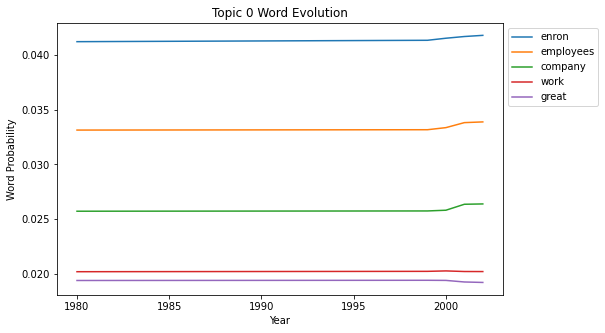

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

x = [1980, 1999, 2000, 2001, 2002]
plt.figure(figsize=(8,5))
plt.plot(x, topic0[0], label = "enron")
plt.plot(x, topic0[1], label = "employees")
plt.plot(x, topic0[2], label = "company")
plt.plot(x, topic0[3], label = "work")
plt.plot(x, topic0[4], label = "great")
plt.xlabel('Year')
plt.ylabel('Word Probability')
plt.title('Topic 0 Word Evolution')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

For topic 0, all five words didn't have much changes. The probabilities of "eron", "employees", and "company" went up slightly and the probabilities of "work" and "great" went down very slightly.

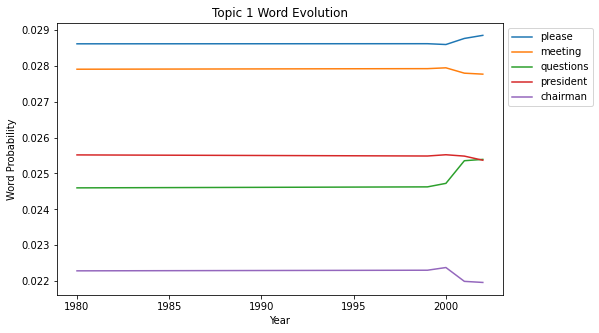

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(x, topic1[0], label = "please")
plt.plot(x, topic1[1], label = "meeting")
plt.plot(x, topic1[2], label = "questions")
plt.plot(x, topic1[3], label = "president")
plt.plot(x, topic1[4], label = "chairman")
plt.xlabel('Year')
plt.ylabel('Word Probability')
plt.title('Topic 1 Word Evolution')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

For topic 1, the probabilities of "please" and "questions" went up, and the probabilities of "meeting", "president", and "chairman" went down. One possible implication could be that the company increased its scale and more inquiries were made.

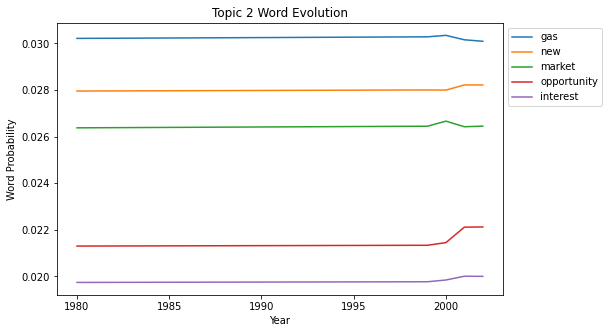

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(x, topic2[0], label = "gas")
plt.plot(x, topic2[1], label = "new")
plt.plot(x, topic2[2], label = "market")
plt.plot(x, topic2[3], label = "opportunity")
plt.plot(x, topic2[4], label = "interest")
plt.xlabel('Year')
plt.ylabel('Word Probability')
plt.title('Topic 2 Word Evolution')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

For topic 2, the probabilities of "new", "opportunity" and "interest" went up, and the probabilities of "gas" went down. The probability of "market" went up in 1999 and then went down. This could imply that as the economy during the millennium year grew, more new opportunities were comming. Also, gas could be replaced by new energy sources or Enron shifted their focus from energy sector to other fields.

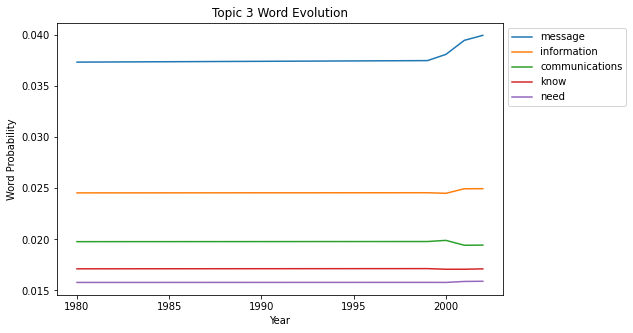

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(x, topic3[0], label = "message")
plt.plot(x, topic3[1], label = "information")
plt.plot(x, topic3[2], label = "communications")
plt.plot(x, topic3[3], label = "know")
plt.plot(x, topic3[4], label = "need")
plt.xlabel('Year')
plt.ylabel('Word Probability')
plt.title('Topic 3 Word Evolution')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

For topic 3, the probabilities of "message" and "information" went up, and the probabilities of "communications" went down. The probability of "know" and "need" didn't quite change. This could imply that more messages came to Kenneth and the company was growing on the right track.



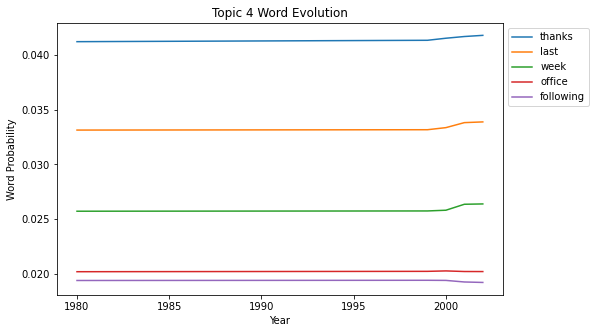

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(x, topic0[0], label = "thanks")
plt.plot(x, topic0[1], label = "last")
plt.plot(x, topic0[2], label = "week")
plt.plot(x, topic0[3], label = "office")
plt.plot(x, topic0[4], label = "following")
plt.xlabel('Year')
plt.ylabel('Word Probability')
plt.title('Topic 4 Word Evolution')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

For topic 4, the probabilities of "thanks", "last" and "week" went up, and other words didn't change a lot. One possible explanation could be that more people chose to resign.

# Variant 5: Network Analysis

## Sub-variant: Multidimensional Scaling

First, we run a multidimensional scaling model on a matrix of how often each pair of people talks to each other. We extracts all employees in the email systems that have ever sent or received emails and construct a square matrix. The $ij^{th}$ entry of the matrix represents the number of emails sent from $employee_i$ to $employee_j$. Then, we use the MDA model from sklearn for the analysis.

In [ ]:
senders = np.unique(new_df['senders'])

recipients = new_df['recipients'].str.split(',',expand = True)
recipients.columns = ['a', 'b', 'c', 'd']
recipients = np.unique(recipients['a'])

employees = np.unique(np.concatenate((senders, recipients), axis = 0))

In [ ]:
new_df['recipients'] = new_df['recipients'].str.split(',',expand = True)

In [ ]:
relation = new_df[['senders', 'recipients', 'text']]
relation = relation.groupby(['senders', 'recipients']).count().reset_index()

In [ ]:
matrix = np.zeros((employees.shape[0], employees.shape[0]))

for i in range(len(relation)):
  x = employees.tolist().index(relation['senders'][i])
  y = employees.tolist().index(relation['recipients'][i])
  matrix[x][y] += relation['text'][i]

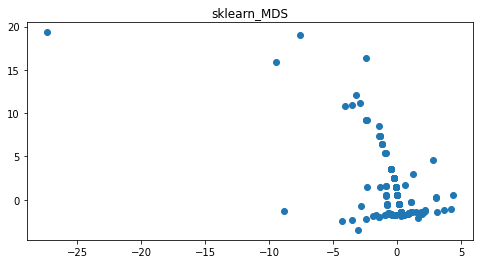

In [ ]:
from sklearn.manifold import MDS
mds = MDS(n_components=2).fit_transform(matrix)

plt.figure(figsize=(8, 4))
plt.title("sklearn MDS for employee connections")
plt.scatter(mds[:,0], mds[:,1])
plt.show()

From the plot, we discovered that most points are located at the bottom-right corner of the graph while a point is at the upper-left corner.

## Sub-variant: Networkx

Then, we use the Networkx model to implement a network to demonstrate the conncections between employees.

In [ ]:
import networkx as nx

G = nx.DiGraph()
for i in range(len(relation)):
  G.add_edge(relation['senders'][i], relation['recipients'][i], weight = relation['text'][i])

(-1.0808111518621444, 1.1349546998739242, -1.06009050488472, 1.195755206346512)

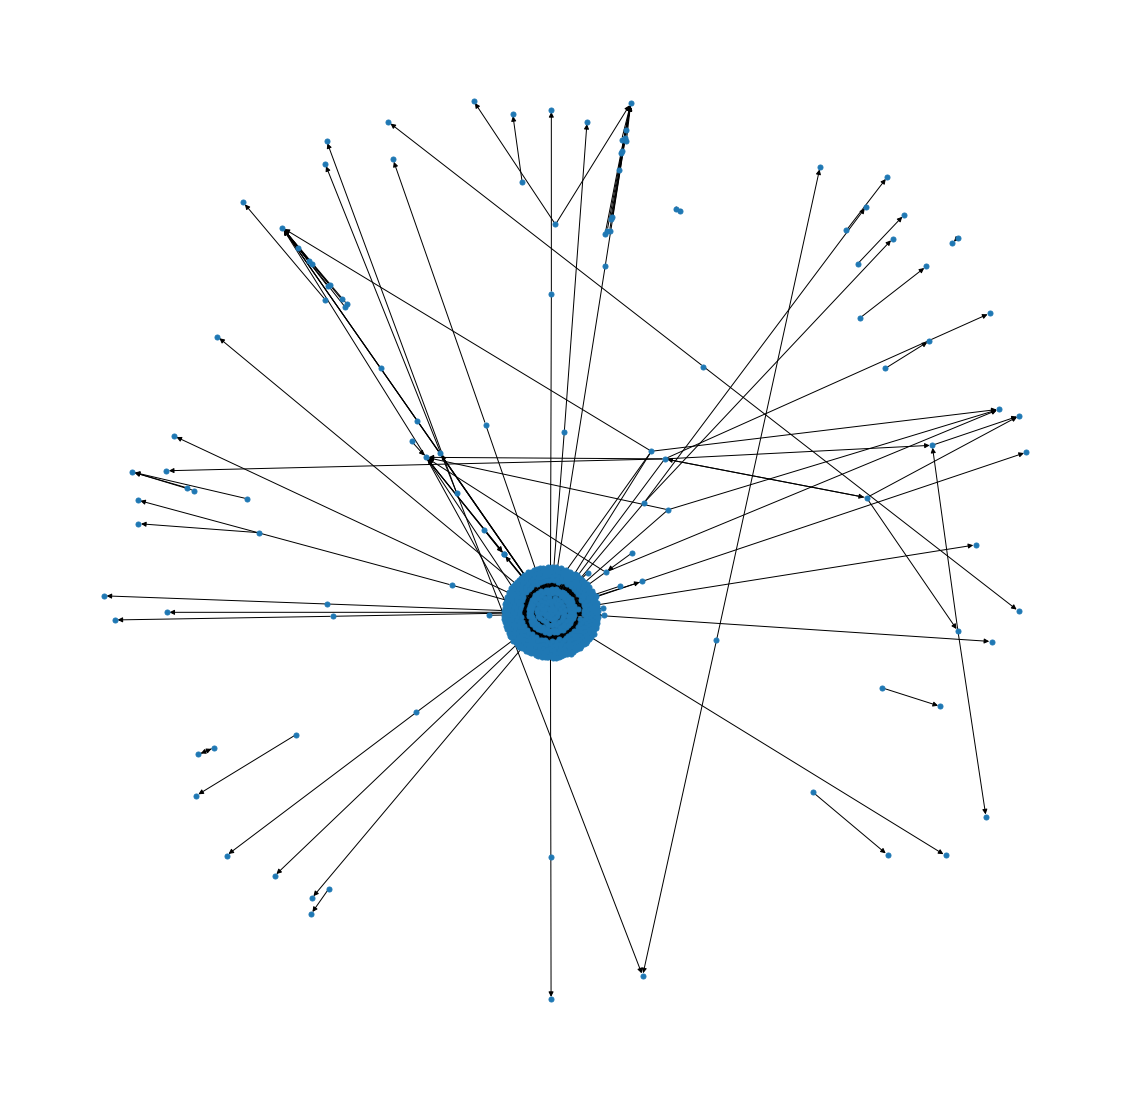

In [ ]:
plt.figure(figsize=(20,20))
nx.draw_networkx(G, with_labels = False, node_size = 25)
plt.axis('off')

This graph shows the overall connections of all employees in Enron. We discovered that most employees are located around the center of the graph, representing they are closely connected and with high centrality. However, there are also nodes of employees spread far away from the center, some of them have weak connections with the central nodes and other are only connected to other nodes spread around.

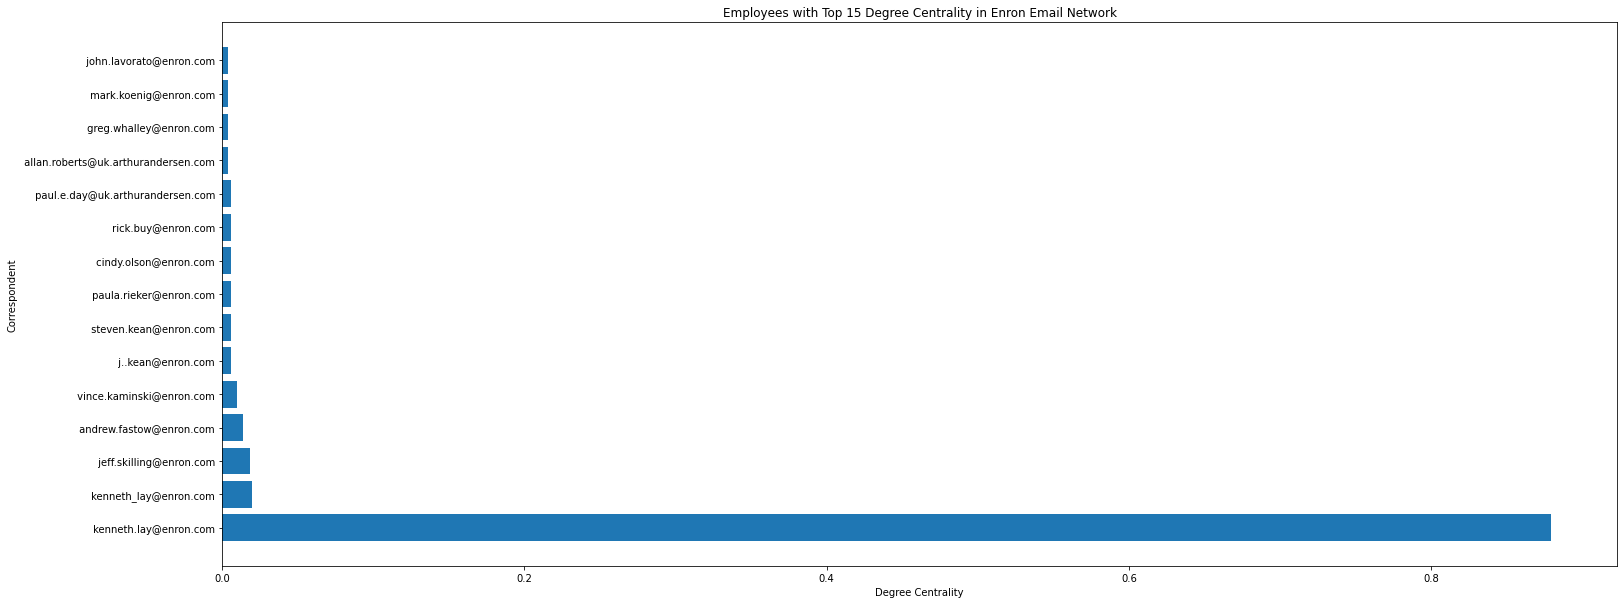

In [ ]:
cent = nx.degree_centrality(G)
name = []
centrality = []

for key, value in cent.items():
    name.append(key)
    centrality.append(value)

cent = pd.DataFrame()    
cent['name'] = name
cent['centrality'] = centrality
cent = cent.sort_values(by='centrality', ascending=False).reset_index()

plt.figure(figsize=(25, 10))
plt.barh(y = 'name', width = 'centrality', data = cent[:15])
plt.xlabel('Degree Centrality')
plt.ylabel('Correspondent')
plt.title('Employees with Top 15 Degree Centrality in Enron Email Network')
plt.show()


In [ ]:
cent['centrality'].describe()

count    712.000000
mean       0.002876
std        0.032905
min        0.001406
25%        0.001406
50%        0.001406
75%        0.001406
max        0.879044
Name: centrality, dtype: float64

After that, we investigated the centrality degree of employees. Degree is the simplest and the most common way of finding important nodes.  It represents the number of people to which a given emplyee is directly connected. The nodes with the highest degree in a social network are the employees who connect with the most people. 

The figure above shows the overall centralities of all employees. It is obvious that Kennenth Lay has the highest centrality, primarily because he is the CEO of the company.

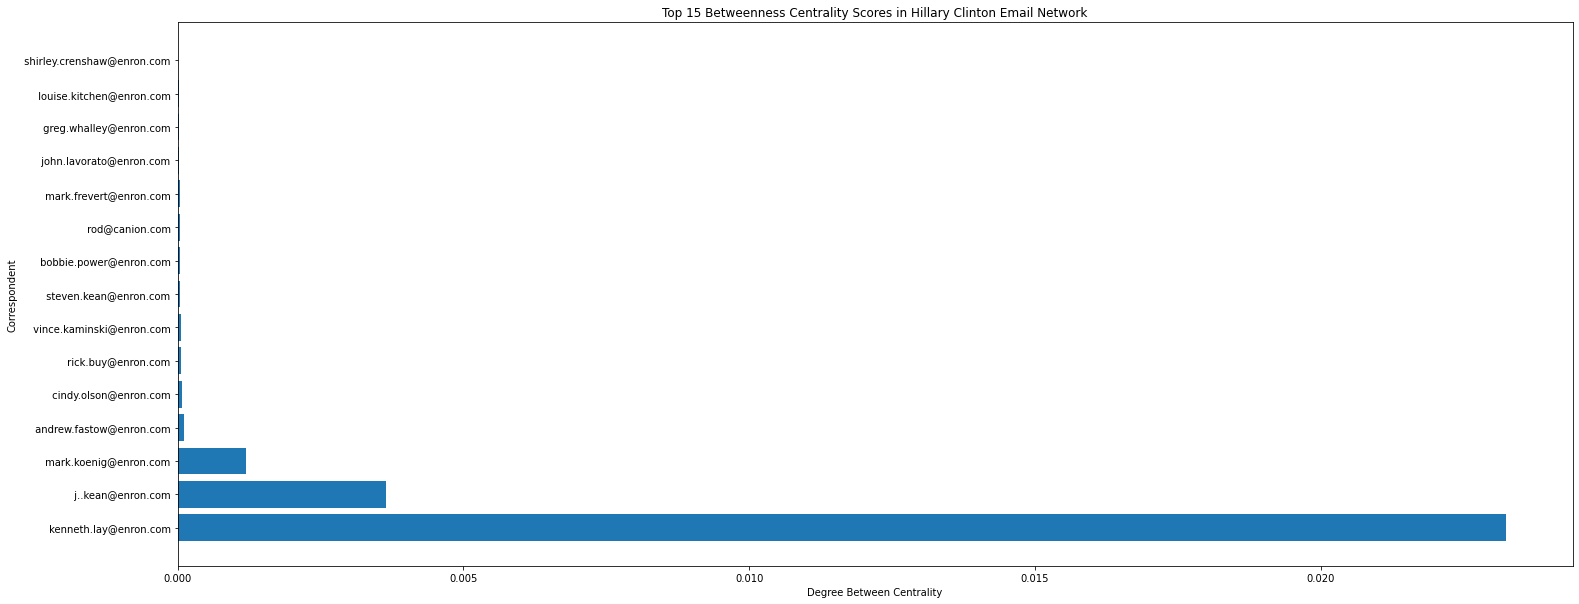

In [ ]:
bet_cent = nx.betweenness_centrality(G)
name = []
bet_centrality = []

for key, value in bet_cent.items():
    name.append(key)
    bet_centrality.append(value)

bet = pd.DataFrame()
bet['name'] = name
bet['bet_centrality'] = bet_centrality
bet = bet.sort_values(by='bet_centrality', ascending=False).reset_index()


plt.figure(figsize=(25, 10))
plt.barh(y = 'name', width = 'bet_centrality', data = bet[:15])
plt.xlabel('Degree Between Centrality')
plt.ylabel('Correspondent')
plt.title('Top 15 Betweenness Centrality Scores in Hillary Clinton Email Network')
plt.show()

Then, we also look at the betweeness centrality of employees. Betweenness centrality looks at all the shortest paths that pass through a particular node and is good at finding nodes that connect two otherwise disparate parts of a network. If an employee is the only one connecting two clusters of employees, every communication between these clusters has to pass through it, then this employee is often referred to as a broker. Betweenness centrality is a quick way to find brokage and thus give us a sense of which employees are important because they stand between groups, giving the network connectivity and cohesion.

The figure above shows the overall betweenness centralities of all employees. It is obvious that kenneth.lay, j.kean, and mark.koenig are the three employees with highest betweeness centrality. These three people are three leaders in the company, so it is reasonable that they are important to the network connectivity.

After demonstrating the overall network, we are also interested in clusters around certain employees. In this way, as long as we find any suspicious employees, we could further look at employees that are closely connected with him. 
In order to demonstrate, we first investigate the cluster around the ceo of Enron as an example.

In [ ]:
# ceo_relation = relation[relation['recipients'] == relation['recipients'][0]].reset_index()

In [ ]:
ceo_senders = relation[relation['recipients'] == relation['recipients'][0]]['senders'].tolist()

In [ ]:
relation['ceo'] = 0
for i in range(len(relation)):
  if relation['senders'][i] in ceo_senders or relation['recipients'][i] in ceo_senders:
    relation['ceo'][i] = 1
ceo_relation = relation[relation['ceo'] == 1].reset_index()

In [ ]:
G = nx.DiGraph()
for i in range(len(ceo_relation)):
  G.add_edge(ceo_relation['senders'][i], ceo_relation['recipients'][i], weight = ceo_relation['text'][i])

(-1.1080210219323636,
 0.5602482269704342,
 -0.3082637368142605,
 1.1243146537244322)

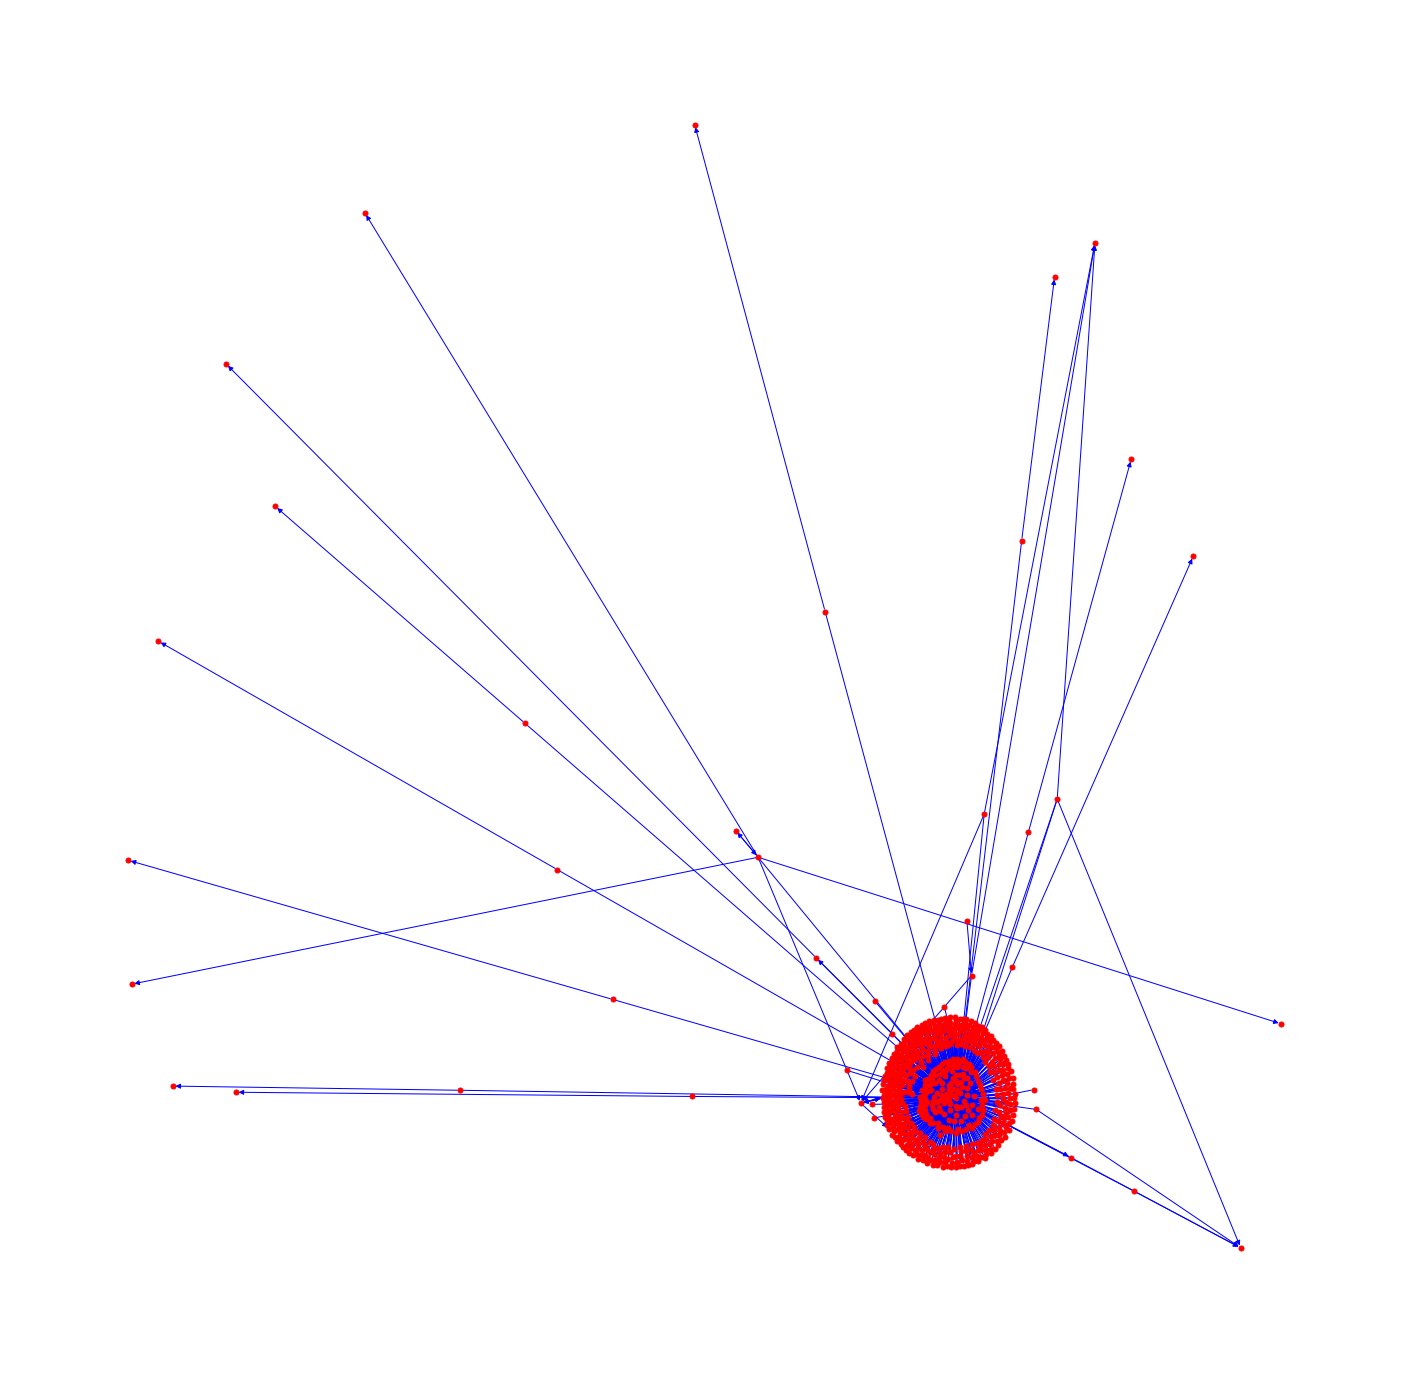

In [ ]:
plt.figure(figsize=(25,25))
nx.draw_networkx(G, with_labels = False, node_size = 25, node_color = 'red', edge_color = 'blue')
plt.axis('off')

The above graph shows the network of all employees that have sent emails to the CEO of Enron. 

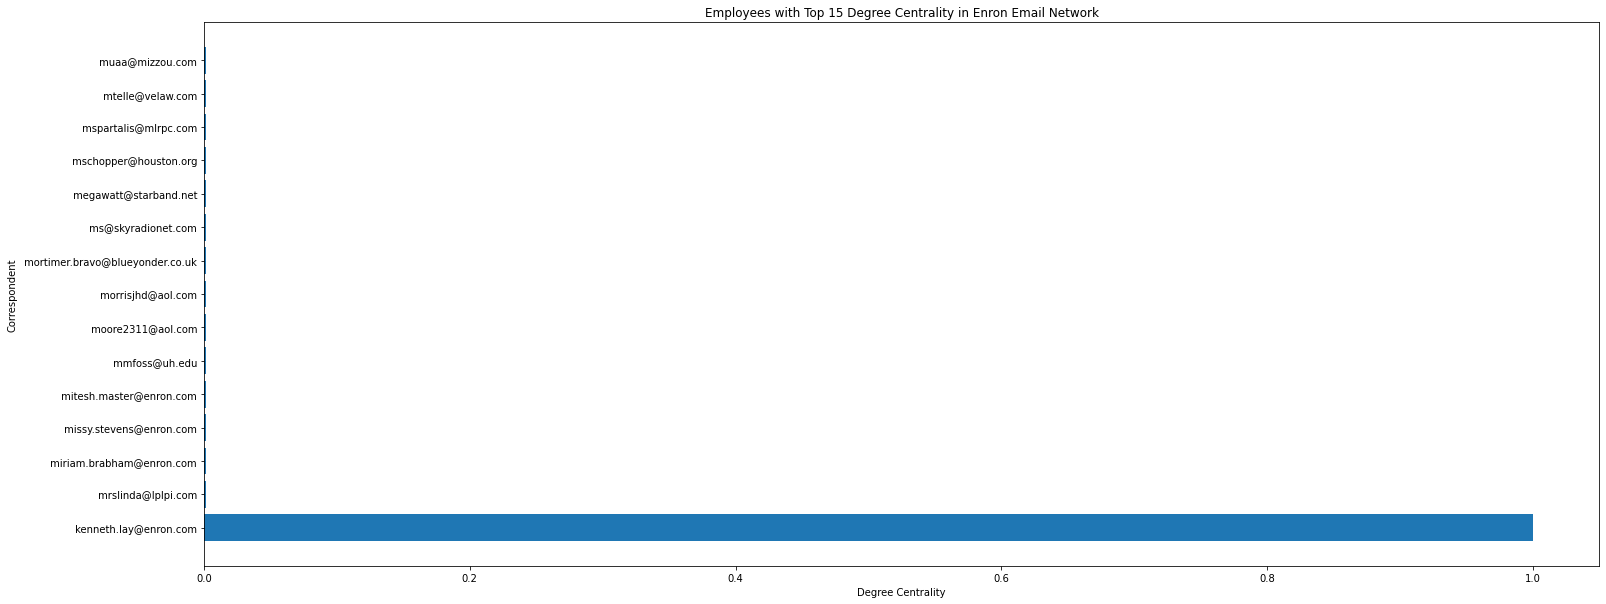

In [ ]:
cent = nx.degree_centrality(G)
name = []
centrality = []

for key, value in cent.items():
    name.append(key)
    centrality.append(value)

cent = pd.DataFrame()    
cent['name'] = name
cent['centrality'] = centrality
cent = cent.sort_values(by='centrality', ascending=False).reset_index()

plt.figure(figsize=(25, 10))
plt.barh(y = 'name', width = 'centrality', data = cent[:15])
plt.xlabel('Degree Centrality')
plt.ylabel('Correspondent')
plt.title('Employees with Top 15 Degree Centrality in Enron Email Network')
plt.show()


The figure above show the centrality of all employees conneted with kenneth.lay. Without any doubt, kenneth.lay himself is with the highest degree centrality with him. However, because almost every employee in the company has connection with the ceo, so this analysis is not very meaningful.

Therefore, we would like to investigate the network for someone who is suspicious as an instance.

Here, we use the result found in Variant 2, where we find that the emails in `topic 1` is suspicious of fraud. Therefore, we take a deeper look into the all senders of emails in `topic 1` and discover that the account steven.kean@enron.com has sent the most amount of emails in this topic. Therefore, we consider him as a suspicious employee and use the network analysis method to investigate the clusters around him.

In [ ]:
suspicious = new_cd_df[new_cd_df['topic_id'] == 1][['senders', 'text']].groupby('senders').count().\
sort_values('text', ascending = False).reset_index()['senders'][0]
suspicious

' steven.kean@enron.com'

In [ ]:
senders = relation[relation['recipients'] == suspicious]['senders'].tolist()
recipients = relation[relation['senders'] == suspicious]['recipients'].tolist()

In [ ]:
all_sus = recipients + senders
all_sus.remove(' kenneth.lay@enron.com',)
all_sus

[' andrew.fastow@enron.com',
 ' rosalee.fleming@enron.com',
 ' kathy.mcmahon@enron.com']

In total, we have found 4 employees that have sent emails to steven.kean or received emails from him and one of them is the ceo kenneth.lay. Because we have alredy demonstrated that the ceo is conncected with almost everyone, exploring the network around him is not meaningful, we remove him from the suspicious list. 

After that, we filter out all emails sent from or to the employees in the suspicious list and construct a network based on these email.

In [ ]:
relation['sus'] = 0
for i in range(len(relation)):
  if relation['senders'][i] in all_sus or relation['recipients'][i] in all_sus:
    relation['sus'][i] = 1
sus_relation = relation[relation['sus'] == 1].reset_index()

In [ ]:
G_sus = nx.DiGraph()
for i in range(len(sus_relation)):
  G_sus.add_edge(sus_relation['senders'][i], sus_relation['recipients'][i], weight = sus_relation['text'][i])

(-0.7470358547982427,
 1.1217190966540178,
 -1.1717842228244446,
 0.8078244402001071)

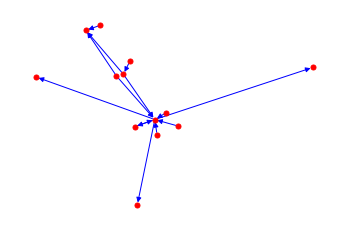

In [ ]:
# plt.figure(figsize=(25,25))
nx.draw_networkx(G_sus, with_labels = False, node_size = 25, node_color = 'red', edge_color = 'blue')
plt.axis('off')

The above graph shows the network around steven.kean, which is much simpler than all previous networks.

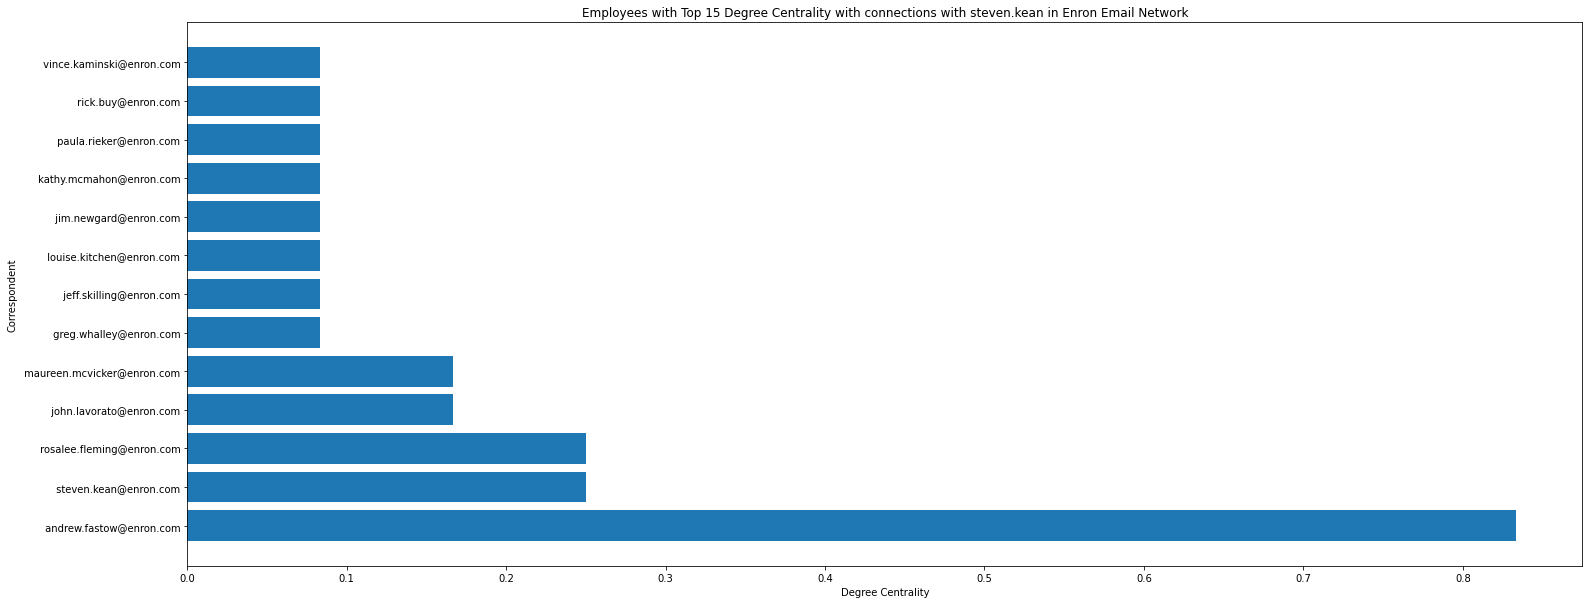

In [ ]:
cent = nx.degree_centrality(G_sus)
name = []
centrality = []

for key, value in cent.items():
    name.append(key)
    centrality.append(value)

cent = pd.DataFrame()    
cent['name'] = name
cent['centrality'] = centrality
cent = cent.sort_values(by='centrality', ascending=False).reset_index()

plt.figure(figsize=(25, 10))
plt.barh(y = 'name', width = 'centrality', data = cent[:15])
plt.xlabel('Degree Centrality')
plt.ylabel('Correspondent')
plt.title('Employees with Top 15 Degree Centrality with connections with steven.kean in Enron Email Network')
plt.show()

Similarly, we compute the degree centrality of all employees in the network of steven.kean. It demonstrates that andrew.fastow has the highest degree centrality, followed by steven.kean, rosalle.fleming, john.lavorato, and maureen.mcvicker, which means these employees are significant in the network of steven.kean. Therefore, if we have found evidence of steven.kean involved in the fraud, these employees can also be suspicious.